In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt

import glob
import gc
from utils import *
from tqdm import tqdm
import pickle
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.layers.convolutional import SeparableConv1D
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python

In [2]:
#GTX1080TI 
#CUDA version == 9.0.176
#CUDNN version == 7501
#tensorflow-gpu == 1.80
#keras == 2.1.4

#cpu
#Keras==2.1.4
#tensorflow==1.14.0

# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105
        self.filters = 16
        self.data_dir = '../data/JHMDB/'
C = Config()

In [5]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [6]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    
    P_faster = Lambda(lambda x: x[:,::4,...])(P)
    P_diff_faster = Lambda(lambda x: poses_diff(x))(P_faster)
    P_diff_faster = Reshape((int(frame_l/4),-1))(P_diff_faster)
    
    return P_diff_slow,P_diff_fast,P_diff_faster


def c1D(x,filters,kernel):
    
    x = SeparableConv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    return x
    

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast,diff_faster = pose_motion(P,frame_l)
    
    
    x = c1D(M,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
   
    x_d_slow = c1D(diff_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
   
    x_d_fast = c1D(diff_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    
    
    
    x_d_faster = c1D(diff_faster,filters,3) 
    x_d_faster = SpatialDropout1D(0.1)(x_d_faster)
    x_d_faster = UpSampling1D(2)(x_d_faster)
    x_d_faster = SpatialDropout1D(0.1)(x_d_faster)
    
    
    x = concatenate([x,x_d_slow,x_d_fast,x_d_faster])
    x = SpatialDropout1D(0.1)(x)
    
    x_shortcut = x
    
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    x = block(x,filters*8)

    x_shortcut = SeparableConv1D(filters*8, kernel_size=3,padding='same',use_bias=False)(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    x_shortcut = LeakyReLU(alpha=0.2)(x_shortcut)
    x_shortcut = MaxPool1D(4)(x_shortcut)
    
    x = add([x,x_shortcut])
    
    return Model(inputs=[M,P],outputs=x)


def build_LDT_Net(C):
   
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    x = FM([M,P])
    
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(C.clc_num, activation='softmax')(x)

    model = Model(inputs=[M,P],outputs=x)
    
    return model

In [7]:
LDT_Net = build_LDT_Net(C)
LDT_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       26521       M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 128)       0           model_1[1][0]                    
__________

# Train and test on GT_split 1

In [8]:
Train = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 268/268 [00:01<00:00, 184.36it/s]


In [9]:
from keras.callbacks import ModelCheckpoint
import keras
lr = 1e-3

LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
'''
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
'''
# checkpoint 报存最好的模型
filepath="weights.GT1best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1400,
                    verbose=True,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 660 samples, validate on 268 samples
Epoch 1/800
660/660 [==============================] - 5s 7ms/step - loss: 3.8942 - acc: 0.0636 - val_loss: 3.2807 - val_acc: 0.0821
Epoch 2/800
660/660 [==============================] - 0s 100us/step - loss: 3.8021 - acc: 0.0561 - val_loss: 3.1487 - val_acc: 0.0933
Epoch 3/800
660/660 [==============================] - 0s 106us/step - loss: 3.5993 - acc: 0.0712 - val_loss: 3.0245 - val_acc: 0.1157
Epoch 4/800
660/660 [==============================] - 0s 91us/step - loss: 3.4801 - acc: 0.0833 - val_loss: 2.9111 - val_acc: 0.1418
Epoch 5/800
660/660 [==============================] - 0s 83us/step - loss: 3.3432 - acc: 0.1015 - val_loss: 2.8120 - val_acc: 0.1791
Epoch 6/800
660/660 [==============================] - 0s 88us/step - loss: 3.1643 - acc: 0.1242 - val_loss: 2.7259 - val_acc: 0.2127
Epoch 7/800
660/660 [==============================] - 0s 83us/step - loss: 3.0731 - acc: 0.1500 - val_loss: 2.6502 - val_acc: 0.2388
Epoch 8/800
660

Epoch 62/800
660/660 [==============================] - 0s 84us/step - loss: 1.2615 - acc: 0.6318 - val_loss: 1.8236 - val_acc: 0.4403
Epoch 63/800
660/660 [==============================] - 0s 87us/step - loss: 1.3492 - acc: 0.5818 - val_loss: 1.8103 - val_acc: 0.4440
Epoch 64/800
660/660 [==============================] - 0s 85us/step - loss: 1.2942 - acc: 0.5970 - val_loss: 1.7931 - val_acc: 0.4440
Epoch 65/800
660/660 [==============================] - 0s 81us/step - loss: 1.2551 - acc: 0.6045 - val_loss: 1.7744 - val_acc: 0.4552
Epoch 66/800
660/660 [==============================] - 0s 92us/step - loss: 1.2685 - acc: 0.5788 - val_loss: 1.7507 - val_acc: 0.4664
Epoch 67/800
660/660 [==============================] - 0s 91us/step - loss: 1.2375 - acc: 0.6000 - val_loss: 1.7277 - val_acc: 0.4813
Epoch 68/800
660/660 [==============================] - 0s 96us/step - loss: 1.2042 - acc: 0.6227 - val_loss: 1.7122 - val_acc: 0.4888
Epoch 69/800
660/660 [==============================] -

Epoch 123/800
660/660 [==============================] - 0s 98us/step - loss: 0.9051 - acc: 0.7136 - val_loss: 1.3442 - val_acc: 0.5784
Epoch 124/800
660/660 [==============================] - 0s 85us/step - loss: 0.9243 - acc: 0.7106 - val_loss: 1.3403 - val_acc: 0.5784
Epoch 125/800
660/660 [==============================] - 0s 85us/step - loss: 0.8839 - acc: 0.7121 - val_loss: 1.3353 - val_acc: 0.5784
Epoch 126/800
660/660 [==============================] - 0s 84us/step - loss: 0.8537 - acc: 0.7318 - val_loss: 1.3302 - val_acc: 0.5821
Epoch 127/800
660/660 [==============================] - 0s 86us/step - loss: 0.8621 - acc: 0.7379 - val_loss: 1.3253 - val_acc: 0.5896
Epoch 128/800
660/660 [==============================] - 0s 89us/step - loss: 0.9073 - acc: 0.7167 - val_loss: 1.3192 - val_acc: 0.5896
Epoch 129/800
660/660 [==============================] - 0s 86us/step - loss: 0.8560 - acc: 0.7227 - val_loss: 1.3148 - val_acc: 0.5896
Epoch 130/800
660/660 [=========================

Epoch 184/800
660/660 [==============================] - 0s 82us/step - loss: 0.8677 - acc: 0.7288 - val_loss: 1.0944 - val_acc: 0.6530
Epoch 185/800
660/660 [==============================] - 0s 92us/step - loss: 0.8736 - acc: 0.7288 - val_loss: 1.0928 - val_acc: 0.6530
Epoch 186/800
660/660 [==============================] - 0s 92us/step - loss: 0.8473 - acc: 0.7439 - val_loss: 1.0911 - val_acc: 0.6530
Epoch 187/800
660/660 [==============================] - 0s 90us/step - loss: 0.8671 - acc: 0.7242 - val_loss: 1.0897 - val_acc: 0.6530
Epoch 188/800
660/660 [==============================] - 0s 91us/step - loss: 0.8968 - acc: 0.7045 - val_loss: 1.0881 - val_acc: 0.6530
Epoch 189/800
660/660 [==============================] - 0s 88us/step - loss: 0.8387 - acc: 0.7348 - val_loss: 1.0867 - val_acc: 0.6567
Epoch 190/800
660/660 [==============================] - 0s 84us/step - loss: 0.8469 - acc: 0.7348 - val_loss: 1.0852 - val_acc: 0.6604
Epoch 191/800
660/660 [=========================

Epoch 245/800
660/660 [==============================] - 0s 87us/step - loss: 0.8438 - acc: 0.7530 - val_loss: 1.0460 - val_acc: 0.6978
Epoch 246/800
660/660 [==============================] - 0s 83us/step - loss: 0.8503 - acc: 0.7242 - val_loss: 1.0457 - val_acc: 0.6978
Epoch 247/800
660/660 [==============================] - 0s 83us/step - loss: 0.8800 - acc: 0.7212 - val_loss: 1.0453 - val_acc: 0.6978
Epoch 248/800
660/660 [==============================] - 0s 88us/step - loss: 0.8826 - acc: 0.7288 - val_loss: 1.0450 - val_acc: 0.6978
Epoch 249/800
660/660 [==============================] - 0s 92us/step - loss: 0.8617 - acc: 0.7242 - val_loss: 1.0447 - val_acc: 0.6978
Epoch 250/800
660/660 [==============================] - 0s 85us/step - loss: 0.8505 - acc: 0.7242 - val_loss: 1.0444 - val_acc: 0.6978
Epoch 251/800
660/660 [==============================] - 0s 88us/step - loss: 0.8665 - acc: 0.7182 - val_loss: 1.0441 - val_acc: 0.6978
Epoch 252/800
660/660 [=========================

Epoch 306/800
660/660 [==============================] - 0s 80us/step - loss: 0.8943 - acc: 0.7106 - val_loss: 1.0365 - val_acc: 0.6866
Epoch 307/800
660/660 [==============================] - 0s 89us/step - loss: 0.8627 - acc: 0.7227 - val_loss: 1.0364 - val_acc: 0.6866
Epoch 308/800
660/660 [==============================] - 0s 83us/step - loss: 0.8380 - acc: 0.7439 - val_loss: 1.0364 - val_acc: 0.6866
Epoch 309/800
660/660 [==============================] - 0s 86us/step - loss: 0.8341 - acc: 0.7424 - val_loss: 1.0364 - val_acc: 0.6866
Epoch 310/800
660/660 [==============================] - 0s 81us/step - loss: 0.8940 - acc: 0.7061 - val_loss: 1.0363 - val_acc: 0.6866
Epoch 311/800
660/660 [==============================] - 0s 89us/step - loss: 0.8580 - acc: 0.7379 - val_loss: 1.0362 - val_acc: 0.6866
Epoch 312/800
660/660 [==============================] - 0s 92us/step - loss: 0.8370 - acc: 0.7455 - val_loss: 1.0362 - val_acc: 0.6828
Epoch 313/800
660/660 [=========================

Epoch 367/800
660/660 [==============================] - 0s 87us/step - loss: 0.8580 - acc: 0.7394 - val_loss: 1.0327 - val_acc: 0.6866
Epoch 368/800
660/660 [==============================] - 0s 86us/step - loss: 0.8353 - acc: 0.7485 - val_loss: 1.0327 - val_acc: 0.6866
Epoch 369/800
660/660 [==============================] - 0s 80us/step - loss: 0.8407 - acc: 0.7364 - val_loss: 1.0326 - val_acc: 0.6866
Epoch 370/800
660/660 [==============================] - 0s 100us/step - loss: 0.8506 - acc: 0.7197 - val_loss: 1.0327 - val_acc: 0.6866
Epoch 371/800
660/660 [==============================] - 0s 84us/step - loss: 0.8469 - acc: 0.7045 - val_loss: 1.0325 - val_acc: 0.6866
Epoch 372/800
660/660 [==============================] - 0s 81us/step - loss: 0.8640 - acc: 0.7197 - val_loss: 1.0324 - val_acc: 0.6866
Epoch 373/800
660/660 [==============================] - 0s 86us/step - loss: 0.8694 - acc: 0.7409 - val_loss: 1.0324 - val_acc: 0.6866
Epoch 374/800
660/660 [========================

Epoch 428/800
660/660 [==============================] - 0s 82us/step - loss: 0.8344 - acc: 0.7364 - val_loss: 1.0308 - val_acc: 0.6828
Epoch 429/800
660/660 [==============================] - 0s 90us/step - loss: 0.8424 - acc: 0.7409 - val_loss: 1.0307 - val_acc: 0.6828
Epoch 430/800
660/660 [==============================] - 0s 88us/step - loss: 0.8614 - acc: 0.7333 - val_loss: 1.0307 - val_acc: 0.6828
Epoch 431/800
660/660 [==============================] - 0s 94us/step - loss: 0.8331 - acc: 0.7364 - val_loss: 1.0306 - val_acc: 0.6828
Epoch 432/800
660/660 [==============================] - 0s 89us/step - loss: 0.8672 - acc: 0.7167 - val_loss: 1.0305 - val_acc: 0.6828
Epoch 433/800
660/660 [==============================] - 0s 90us/step - loss: 0.8277 - acc: 0.7364 - val_loss: 1.0305 - val_acc: 0.6828
Epoch 434/800
660/660 [==============================] - 0s 85us/step - loss: 0.8705 - acc: 0.7167 - val_loss: 1.0305 - val_acc: 0.6828
Epoch 435/800
660/660 [=========================

Epoch 489/800
660/660 [==============================] - 0s 87us/step - loss: 0.8241 - acc: 0.7318 - val_loss: 1.0282 - val_acc: 0.6866
Epoch 490/800
660/660 [==============================] - 0s 84us/step - loss: 0.8468 - acc: 0.7258 - val_loss: 1.0281 - val_acc: 0.6866
Epoch 491/800
660/660 [==============================] - 0s 90us/step - loss: 0.8984 - acc: 0.6939 - val_loss: 1.0281 - val_acc: 0.6866
Epoch 492/800
660/660 [==============================] - 0s 89us/step - loss: 0.8200 - acc: 0.7409 - val_loss: 1.0280 - val_acc: 0.6866
Epoch 493/800
660/660 [==============================] - 0s 83us/step - loss: 0.8365 - acc: 0.7485 - val_loss: 1.0280 - val_acc: 0.6866
Epoch 494/800
660/660 [==============================] - 0s 90us/step - loss: 0.8510 - acc: 0.7348 - val_loss: 1.0280 - val_acc: 0.6866
Epoch 495/800
660/660 [==============================] - 0s 85us/step - loss: 0.9023 - acc: 0.7121 - val_loss: 1.0280 - val_acc: 0.6866
Epoch 496/800
660/660 [=========================

Epoch 550/800
660/660 [==============================] - 0s 83us/step - loss: 0.8326 - acc: 0.7273 - val_loss: 1.0257 - val_acc: 0.6866
Epoch 551/800
660/660 [==============================] - 0s 92us/step - loss: 0.8400 - acc: 0.7318 - val_loss: 1.0257 - val_acc: 0.6866
Epoch 552/800
660/660 [==============================] - 0s 87us/step - loss: 0.8625 - acc: 0.7485 - val_loss: 1.0256 - val_acc: 0.6866
Epoch 553/800
660/660 [==============================] - 0s 95us/step - loss: 0.8201 - acc: 0.7318 - val_loss: 1.0256 - val_acc: 0.6866
Epoch 554/800
660/660 [==============================] - 0s 87us/step - loss: 0.8236 - acc: 0.7424 - val_loss: 1.0255 - val_acc: 0.6866
Epoch 555/800
660/660 [==============================] - 0s 93us/step - loss: 0.8434 - acc: 0.7379 - val_loss: 1.0255 - val_acc: 0.6866
Epoch 556/800
660/660 [==============================] - 0s 88us/step - loss: 0.8505 - acc: 0.7333 - val_loss: 1.0254 - val_acc: 0.6866
Epoch 557/800
660/660 [=========================

Epoch 611/800
660/660 [==============================] - 0s 81us/step - loss: 0.8310 - acc: 0.7273 - val_loss: 1.0227 - val_acc: 0.6828
Epoch 612/800
660/660 [==============================] - 0s 85us/step - loss: 0.8342 - acc: 0.7227 - val_loss: 1.0227 - val_acc: 0.6828
Epoch 613/800
660/660 [==============================] - 0s 94us/step - loss: 0.8152 - acc: 0.7409 - val_loss: 1.0226 - val_acc: 0.6828
Epoch 614/800
660/660 [==============================] - 0s 84us/step - loss: 0.8475 - acc: 0.7424 - val_loss: 1.0225 - val_acc: 0.6828
Epoch 615/800
660/660 [==============================] - 0s 85us/step - loss: 0.8391 - acc: 0.7318 - val_loss: 1.0224 - val_acc: 0.6828
Epoch 616/800
660/660 [==============================] - 0s 86us/step - loss: 0.8110 - acc: 0.7409 - val_loss: 1.0224 - val_acc: 0.6828
Epoch 617/800
660/660 [==============================] - 0s 85us/step - loss: 0.8431 - acc: 0.7348 - val_loss: 1.0223 - val_acc: 0.6828
Epoch 618/800
660/660 [=========================

Epoch 672/800
660/660 [==============================] - 0s 79us/step - loss: 0.8906 - acc: 0.7212 - val_loss: 1.0204 - val_acc: 0.6828
Epoch 673/800
660/660 [==============================] - 0s 78us/step - loss: 0.8558 - acc: 0.7182 - val_loss: 1.0203 - val_acc: 0.6828
Epoch 674/800
660/660 [==============================] - 0s 90us/step - loss: 0.8430 - acc: 0.7242 - val_loss: 1.0203 - val_acc: 0.6828
Epoch 675/800
660/660 [==============================] - 0s 94us/step - loss: 0.7995 - acc: 0.7348 - val_loss: 1.0203 - val_acc: 0.6828
Epoch 676/800
660/660 [==============================] - 0s 95us/step - loss: 0.8359 - acc: 0.7242 - val_loss: 1.0202 - val_acc: 0.6828
Epoch 677/800
660/660 [==============================] - 0s 77us/step - loss: 0.8471 - acc: 0.7242 - val_loss: 1.0202 - val_acc: 0.6828
Epoch 678/800
660/660 [==============================] - 0s 91us/step - loss: 0.8238 - acc: 0.7530 - val_loss: 1.0201 - val_acc: 0.6828
Epoch 679/800
660/660 [=========================

Epoch 733/800
660/660 [==============================] - 0s 84us/step - loss: 0.8371 - acc: 0.7409 - val_loss: 1.0175 - val_acc: 0.6828
Epoch 734/800
660/660 [==============================] - 0s 84us/step - loss: 0.8005 - acc: 0.7621 - val_loss: 1.0174 - val_acc: 0.6828
Epoch 735/800
660/660 [==============================] - 0s 91us/step - loss: 0.8284 - acc: 0.7333 - val_loss: 1.0174 - val_acc: 0.6828
Epoch 736/800
660/660 [==============================] - 0s 81us/step - loss: 0.8141 - acc: 0.7439 - val_loss: 1.0174 - val_acc: 0.6828
Epoch 737/800
660/660 [==============================] - 0s 84us/step - loss: 0.8103 - acc: 0.7273 - val_loss: 1.0173 - val_acc: 0.6828
Epoch 738/800
660/660 [==============================] - 0s 90us/step - loss: 0.8637 - acc: 0.7152 - val_loss: 1.0172 - val_acc: 0.6828
Epoch 739/800
660/660 [==============================] - 0s 88us/step - loss: 0.8126 - acc: 0.7591 - val_loss: 1.0172 - val_acc: 0.6828
Epoch 740/800
660/660 [=========================

Epoch 794/800
660/660 [==============================] - 0s 86us/step - loss: 0.8283 - acc: 0.7182 - val_loss: 1.0149 - val_acc: 0.6866
Epoch 795/800
660/660 [==============================] - 0s 90us/step - loss: 0.8738 - acc: 0.7136 - val_loss: 1.0148 - val_acc: 0.6866
Epoch 796/800
660/660 [==============================] - 0s 86us/step - loss: 0.8561 - acc: 0.7333 - val_loss: 1.0147 - val_acc: 0.6866
Epoch 797/800
660/660 [==============================] - 0s 95us/step - loss: 0.8201 - acc: 0.7470 - val_loss: 1.0147 - val_acc: 0.6866
Epoch 798/800
660/660 [==============================] - 0s 87us/step - loss: 0.8750 - acc: 0.7167 - val_loss: 1.0146 - val_acc: 0.6866
Epoch 799/800
660/660 [==============================] - 0s 92us/step - loss: 0.8588 - acc: 0.7242 - val_loss: 1.0146 - val_acc: 0.6866
Epoch 800/800
660/660 [==============================] - 0s 81us/step - loss: 0.8260 - acc: 0.7364 - val_loss: 1.0145 - val_acc: 0.6866
Train on 660 samples, validate on 268 samples
Ep


Epoch 00040: val_acc did not improve
Epoch 41/1400
660/660 [==============================] - 0s 84us/step - loss: 0.5805 - acc: 0.8182 - val_loss: 1.0715 - val_acc: 0.6716

Epoch 00041: val_acc did not improve
Epoch 42/1400
660/660 [==============================] - 0s 84us/step - loss: 0.6057 - acc: 0.8000 - val_loss: 1.0602 - val_acc: 0.6791

Epoch 00042: val_acc did not improve
Epoch 43/1400
660/660 [==============================] - 0s 95us/step - loss: 0.5570 - acc: 0.8227 - val_loss: 1.0412 - val_acc: 0.6828

Epoch 00043: val_acc did not improve
Epoch 44/1400
660/660 [==============================] - 0s 92us/step - loss: 0.6022 - acc: 0.7894 - val_loss: 1.0212 - val_acc: 0.6940

Epoch 00044: val_acc did not improve
Epoch 45/1400
660/660 [==============================] - 0s 88us/step - loss: 0.5847 - acc: 0.8197 - val_loss: 1.0014 - val_acc: 0.6978

Epoch 00045: val_acc did not improve
Epoch 46/1400
660/660 [==============================] - 0s 81us/step - loss: 0.6175 - acc: 


Epoch 00087: val_acc did not improve
Epoch 88/1400
660/660 [==============================] - 0s 87us/step - loss: 0.4592 - acc: 0.8652 - val_loss: 1.0408 - val_acc: 0.6791

Epoch 00088: val_acc did not improve
Epoch 89/1400
660/660 [==============================] - 0s 87us/step - loss: 0.3977 - acc: 0.8894 - val_loss: 1.0421 - val_acc: 0.6754

Epoch 00089: val_acc did not improve
Epoch 90/1400
660/660 [==============================] - 0s 86us/step - loss: 0.4529 - acc: 0.8515 - val_loss: 1.0482 - val_acc: 0.6754

Epoch 00090: val_acc did not improve
Epoch 91/1400
660/660 [==============================] - 0s 89us/step - loss: 0.4393 - acc: 0.8742 - val_loss: 1.0658 - val_acc: 0.6642

Epoch 00091: val_acc did not improve
Epoch 92/1400
660/660 [==============================] - 0s 84us/step - loss: 0.4725 - acc: 0.8606 - val_loss: 1.0686 - val_acc: 0.6567

Epoch 00092: val_acc did not improve
Epoch 93/1400
660/660 [==============================] - 0s 83us/step - loss: 0.4499 - acc: 


Epoch 00134: val_acc did not improve
Epoch 135/1400
660/660 [==============================] - 0s 87us/step - loss: 0.3605 - acc: 0.8833 - val_loss: 1.0258 - val_acc: 0.6828

Epoch 00135: val_acc did not improve
Epoch 136/1400
660/660 [==============================] - 0s 85us/step - loss: 0.3389 - acc: 0.9000 - val_loss: 1.0020 - val_acc: 0.6903

Epoch 00136: val_acc did not improve
Epoch 137/1400
660/660 [==============================] - 0s 94us/step - loss: 0.3651 - acc: 0.8879 - val_loss: 0.9789 - val_acc: 0.7015

Epoch 00137: val_acc did not improve
Epoch 138/1400
660/660 [==============================] - 0s 83us/step - loss: 0.3401 - acc: 0.9045 - val_loss: 0.9601 - val_acc: 0.7052

Epoch 00138: val_acc did not improve
Epoch 139/1400
660/660 [==============================] - 0s 86us/step - loss: 0.3708 - acc: 0.8879 - val_loss: 0.9450 - val_acc: 0.7090

Epoch 00139: val_acc did not improve
Epoch 140/1400
660/660 [==============================] - 0s 83us/step - loss: 0.3354 -

660/660 [==============================] - 0s 87us/step - loss: 0.2958 - acc: 0.9182 - val_loss: 0.9018 - val_acc: 0.7500

Epoch 00180: val_acc did not improve
Epoch 181/1400
660/660 [==============================] - 0s 79us/step - loss: 0.3111 - acc: 0.8909 - val_loss: 0.9075 - val_acc: 0.7463

Epoch 00181: val_acc did not improve
Epoch 182/1400
660/660 [==============================] - 0s 90us/step - loss: 0.2691 - acc: 0.9182 - val_loss: 0.9144 - val_acc: 0.7351

Epoch 00182: val_acc did not improve
Epoch 183/1400
660/660 [==============================] - 0s 91us/step - loss: 0.2788 - acc: 0.9197 - val_loss: 0.9211 - val_acc: 0.7276

Epoch 00183: val_acc did not improve
Epoch 184/1400
660/660 [==============================] - 0s 82us/step - loss: 0.2772 - acc: 0.9167 - val_loss: 0.9311 - val_acc: 0.7239

Epoch 00184: val_acc did not improve
Epoch 185/1400
660/660 [==============================] - 0s 84us/step - loss: 0.2661 - acc: 0.9197 - val_loss: 0.9432 - val_acc: 0.7201

Ep


Epoch 00225: val_acc did not improve
Epoch 226/1400
660/660 [==============================] - 0s 91us/step - loss: 0.2425 - acc: 0.9364 - val_loss: 0.8171 - val_acc: 0.7799

Epoch 00226: val_acc did not improve
Epoch 227/1400
660/660 [==============================] - 0s 78us/step - loss: 0.2309 - acc: 0.9258 - val_loss: 0.8147 - val_acc: 0.7836

Epoch 00227: val_acc did not improve
Epoch 228/1400
660/660 [==============================] - 0s 87us/step - loss: 0.2243 - acc: 0.9318 - val_loss: 0.8156 - val_acc: 0.7873

Epoch 00228: val_acc did not improve
Epoch 229/1400
660/660 [==============================] - 0s 94us/step - loss: 0.2281 - acc: 0.9288 - val_loss: 0.8191 - val_acc: 0.7873

Epoch 00229: val_acc did not improve
Epoch 230/1400
660/660 [==============================] - 0s 88us/step - loss: 0.2310 - acc: 0.9303 - val_loss: 0.8226 - val_acc: 0.7836

Epoch 00230: val_acc did not improve
Epoch 231/1400
660/660 [==============================] - 0s 89us/step - loss: 0.2468 -


Epoch 00272: val_acc did not improve
Epoch 273/1400
660/660 [==============================] - 0s 78us/step - loss: 0.1976 - acc: 0.9364 - val_loss: 0.8421 - val_acc: 0.7799

Epoch 00273: val_acc did not improve
Epoch 274/1400
660/660 [==============================] - 0s 86us/step - loss: 0.1700 - acc: 0.9561 - val_loss: 0.8398 - val_acc: 0.7761

Epoch 00274: val_acc did not improve
Epoch 275/1400
660/660 [==============================] - 0s 88us/step - loss: 0.1762 - acc: 0.9439 - val_loss: 0.8366 - val_acc: 0.7761

Epoch 00275: val_acc did not improve
Epoch 276/1400
660/660 [==============================] - 0s 86us/step - loss: 0.2042 - acc: 0.9348 - val_loss: 0.8349 - val_acc: 0.7724

Epoch 00276: val_acc did not improve
Epoch 277/1400
660/660 [==============================] - 0s 93us/step - loss: 0.2095 - acc: 0.9394 - val_loss: 0.8310 - val_acc: 0.7761

Epoch 00277: val_acc did not improve
Epoch 278/1400
660/660 [==============================] - 0s 93us/step - loss: 0.1841 -


Epoch 00319: val_acc did not improve
Epoch 320/1400
660/660 [==============================] - 0s 91us/step - loss: 0.2240 - acc: 0.9303 - val_loss: 0.9360 - val_acc: 0.7500

Epoch 00320: val_acc did not improve
Epoch 321/1400
660/660 [==============================] - 0s 85us/step - loss: 0.1828 - acc: 0.9439 - val_loss: 0.9340 - val_acc: 0.7575

Epoch 00321: val_acc did not improve
Epoch 322/1400
660/660 [==============================] - 0s 89us/step - loss: 0.1538 - acc: 0.9545 - val_loss: 0.9287 - val_acc: 0.7612

Epoch 00322: val_acc did not improve
Epoch 323/1400
660/660 [==============================] - 0s 91us/step - loss: 0.1548 - acc: 0.9591 - val_loss: 0.9245 - val_acc: 0.7687

Epoch 00323: val_acc did not improve
Epoch 324/1400
660/660 [==============================] - 0s 89us/step - loss: 0.1447 - acc: 0.9545 - val_loss: 0.9269 - val_acc: 0.7612

Epoch 00324: val_acc did not improve
Epoch 325/1400
660/660 [==============================] - 0s 86us/step - loss: 0.1671 -


Epoch 00366: val_acc did not improve
Epoch 367/1400
660/660 [==============================] - 0s 81us/step - loss: 0.1672 - acc: 0.9424 - val_loss: 0.8795 - val_acc: 0.7724

Epoch 00367: val_acc did not improve
Epoch 368/1400
660/660 [==============================] - 0s 90us/step - loss: 0.1233 - acc: 0.9652 - val_loss: 0.8852 - val_acc: 0.7687

Epoch 00368: val_acc did not improve
Epoch 369/1400
660/660 [==============================] - 0s 89us/step - loss: 0.1381 - acc: 0.9591 - val_loss: 0.8932 - val_acc: 0.7612

Epoch 00369: val_acc did not improve
Epoch 370/1400
660/660 [==============================] - 0s 81us/step - loss: 0.1375 - acc: 0.9545 - val_loss: 0.9021 - val_acc: 0.7575

Epoch 00370: val_acc did not improve
Epoch 371/1400
660/660 [==============================] - 0s 85us/step - loss: 0.1665 - acc: 0.9530 - val_loss: 0.9212 - val_acc: 0.7425

Epoch 00371: val_acc did not improve
Epoch 372/1400
660/660 [==============================] - 0s 88us/step - loss: 0.1630 -


Epoch 00413: val_acc did not improve
Epoch 414/1400
660/660 [==============================] - 0s 89us/step - loss: 0.1453 - acc: 0.9515 - val_loss: 0.8431 - val_acc: 0.7687

Epoch 00414: val_acc did not improve
Epoch 415/1400
660/660 [==============================] - 0s 82us/step - loss: 0.1126 - acc: 0.9636 - val_loss: 0.8468 - val_acc: 0.7761

Epoch 00415: val_acc did not improve
Epoch 416/1400
660/660 [==============================] - 0s 84us/step - loss: 0.1425 - acc: 0.9545 - val_loss: 0.8548 - val_acc: 0.7761

Epoch 00416: val_acc did not improve
Epoch 417/1400
660/660 [==============================] - 0s 83us/step - loss: 0.1203 - acc: 0.9697 - val_loss: 0.8616 - val_acc: 0.7799

Epoch 00417: val_acc did not improve
Epoch 418/1400
660/660 [==============================] - 0s 86us/step - loss: 0.1411 - acc: 0.9561 - val_loss: 0.8724 - val_acc: 0.7724

Epoch 00418: val_acc did not improve
Epoch 419/1400
660/660 [==============================] - 0s 80us/step - loss: 0.1258 -


Epoch 00460: val_acc did not improve
Epoch 461/1400
660/660 [==============================] - 0s 96us/step - loss: 0.1082 - acc: 0.9652 - val_loss: 0.8396 - val_acc: 0.7873

Epoch 00461: val_acc did not improve
Epoch 462/1400
660/660 [==============================] - 0s 95us/step - loss: 0.1380 - acc: 0.9621 - val_loss: 0.8617 - val_acc: 0.7761

Epoch 00462: val_acc did not improve
Epoch 463/1400
660/660 [==============================] - 0s 83us/step - loss: 0.1156 - acc: 0.9636 - val_loss: 0.8801 - val_acc: 0.7649

Epoch 00463: val_acc did not improve
Epoch 464/1400
660/660 [==============================] - 0s 86us/step - loss: 0.1254 - acc: 0.9576 - val_loss: 0.8985 - val_acc: 0.7612

Epoch 00464: val_acc did not improve
Epoch 465/1400
660/660 [==============================] - 0s 95us/step - loss: 0.1268 - acc: 0.9636 - val_loss: 0.9101 - val_acc: 0.7649

Epoch 00465: val_acc did not improve
Epoch 466/1400
660/660 [==============================] - 0s 87us/step - loss: 0.1177 -


Epoch 00507: val_acc did not improve
Epoch 508/1400
660/660 [==============================] - 0s 74us/step - loss: 0.1038 - acc: 0.9727 - val_loss: 0.8685 - val_acc: 0.7910

Epoch 00508: val_acc did not improve
Epoch 509/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0928 - acc: 0.9758 - val_loss: 0.8642 - val_acc: 0.7948

Epoch 00509: val_acc did not improve
Epoch 510/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0942 - acc: 0.9788 - val_loss: 0.8555 - val_acc: 0.8022

Epoch 00510: val_acc did not improve
Epoch 511/1400
660/660 [==============================] - 0s 84us/step - loss: 0.1270 - acc: 0.9576 - val_loss: 0.8511 - val_acc: 0.7985

Epoch 00511: val_acc did not improve
Epoch 512/1400
660/660 [==============================] - 0s 85us/step - loss: 0.1088 - acc: 0.9682 - val_loss: 0.8486 - val_acc: 0.7948

Epoch 00512: val_acc did not improve
Epoch 513/1400
660/660 [==============================] - 0s 84us/step - loss: 0.1190 -


Epoch 00554: val_acc did not improve
Epoch 555/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0885 - acc: 0.9788 - val_loss: 0.9665 - val_acc: 0.7612

Epoch 00555: val_acc did not improve
Epoch 556/1400
660/660 [==============================] - 0s 94us/step - loss: 0.0895 - acc: 0.9788 - val_loss: 0.9678 - val_acc: 0.7612

Epoch 00556: val_acc did not improve
Epoch 557/1400
660/660 [==============================] - 0s 97us/step - loss: 0.1048 - acc: 0.9758 - val_loss: 0.9787 - val_acc: 0.7612

Epoch 00557: val_acc did not improve
Epoch 558/1400
660/660 [==============================] - 0s 84us/step - loss: 0.1095 - acc: 0.9636 - val_loss: 1.0087 - val_acc: 0.7425

Epoch 00558: val_acc did not improve
Epoch 559/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0893 - acc: 0.9667 - val_loss: 1.0395 - val_acc: 0.7351

Epoch 00559: val_acc did not improve
Epoch 560/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0960 -


Epoch 00601: val_acc did not improve
Epoch 602/1400
660/660 [==============================] - 0s 82us/step - loss: 0.1004 - acc: 0.9652 - val_loss: 1.0026 - val_acc: 0.7500

Epoch 00602: val_acc did not improve
Epoch 603/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0888 - acc: 0.9697 - val_loss: 0.9895 - val_acc: 0.7575

Epoch 00603: val_acc did not improve
Epoch 604/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0948 - acc: 0.9742 - val_loss: 0.9949 - val_acc: 0.7575

Epoch 00604: val_acc did not improve
Epoch 605/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0685 - acc: 0.9833 - val_loss: 0.9989 - val_acc: 0.7612

Epoch 00605: val_acc did not improve
Epoch 606/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0981 - acc: 0.9697 - val_loss: 0.9964 - val_acc: 0.7612

Epoch 00606: val_acc did not improve
Epoch 607/1400
660/660 [==============================] - 0s 92us/step - loss: 0.0968 -


Epoch 00647: val_acc did not improve
Epoch 648/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0756 - acc: 0.9848 - val_loss: 0.8376 - val_acc: 0.8022

Epoch 00648: val_acc did not improve
Epoch 649/1400
660/660 [==============================] - 0s 77us/step - loss: 0.0626 - acc: 0.9894 - val_loss: 0.8395 - val_acc: 0.8022

Epoch 00649: val_acc did not improve
Epoch 650/1400
660/660 [==============================] - 0s 92us/step - loss: 0.0902 - acc: 0.9727 - val_loss: 0.8466 - val_acc: 0.7948

Epoch 00650: val_acc did not improve
Epoch 651/1400
660/660 [==============================] - 0s 95us/step - loss: 0.0641 - acc: 0.9818 - val_loss: 0.8585 - val_acc: 0.7910

Epoch 00651: val_acc did not improve
Epoch 652/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0827 - acc: 0.9788 - val_loss: 0.8723 - val_acc: 0.7799

Epoch 00652: val_acc did not improve
Epoch 653/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0904 -


Epoch 00694: val_acc did not improve
Epoch 695/1400
660/660 [==============================] - 0s 96us/step - loss: 0.0613 - acc: 0.9788 - val_loss: 0.8962 - val_acc: 0.7799

Epoch 00695: val_acc did not improve
Epoch 696/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0686 - acc: 0.9758 - val_loss: 0.9006 - val_acc: 0.7799

Epoch 00696: val_acc did not improve
Epoch 697/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0748 - acc: 0.9758 - val_loss: 0.9016 - val_acc: 0.7836

Epoch 00697: val_acc did not improve
Epoch 698/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0730 - acc: 0.9833 - val_loss: 0.9035 - val_acc: 0.7873

Epoch 00698: val_acc did not improve
Epoch 699/1400
660/660 [==============================] - 0s 80us/step - loss: 0.0562 - acc: 0.9924 - val_loss: 0.9096 - val_acc: 0.7873

Epoch 00699: val_acc did not improve
Epoch 700/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0758 -


Epoch 00741: val_acc did not improve
Epoch 742/1400
660/660 [==============================] - 0s 81us/step - loss: 0.0651 - acc: 0.9848 - val_loss: 0.8760 - val_acc: 0.7799

Epoch 00742: val_acc did not improve
Epoch 743/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0583 - acc: 0.9879 - val_loss: 0.8829 - val_acc: 0.7799

Epoch 00743: val_acc did not improve
Epoch 744/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0630 - acc: 0.9864 - val_loss: 0.8872 - val_acc: 0.7836

Epoch 00744: val_acc did not improve
Epoch 745/1400
660/660 [==============================] - 0s 95us/step - loss: 0.0719 - acc: 0.9848 - val_loss: 0.8904 - val_acc: 0.7836

Epoch 00745: val_acc did not improve
Epoch 746/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0638 - acc: 0.9773 - val_loss: 0.8905 - val_acc: 0.7873

Epoch 00746: val_acc did not improve
Epoch 747/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0738 -

660/660 [==============================] - 0s 93us/step - loss: 0.0481 - acc: 0.9833 - val_loss: 0.8926 - val_acc: 0.7985

Epoch 00788: val_acc did not improve
Epoch 789/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0561 - acc: 0.9833 - val_loss: 0.8923 - val_acc: 0.8097

Epoch 00789: val_acc did not improve
Epoch 790/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0667 - acc: 0.9788 - val_loss: 0.8964 - val_acc: 0.8097

Epoch 00790: val_acc did not improve
Epoch 791/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0569 - acc: 0.9833 - val_loss: 0.9006 - val_acc: 0.8022

Epoch 00791: val_acc did not improve
Epoch 792/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0708 - acc: 0.9758 - val_loss: 0.9037 - val_acc: 0.7948

Epoch 00792: val_acc did not improve
Epoch 793/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0573 - acc: 0.9818 - val_loss: 0.9036 - val_acc: 0.7985

Ep

660/660 [==============================] - 0s 87us/step - loss: 0.0473 - acc: 0.9955 - val_loss: 0.9896 - val_acc: 0.7799

Epoch 00835: val_acc did not improve
Epoch 836/1400
660/660 [==============================] - 0s 95us/step - loss: 0.0663 - acc: 0.9818 - val_loss: 0.9781 - val_acc: 0.7724

Epoch 00836: val_acc did not improve
Epoch 837/1400
660/660 [==============================] - 0s 77us/step - loss: 0.0616 - acc: 0.9833 - val_loss: 0.9762 - val_acc: 0.7724

Epoch 00837: val_acc did not improve
Epoch 838/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0504 - acc: 0.9864 - val_loss: 0.9734 - val_acc: 0.7799

Epoch 00838: val_acc did not improve
Epoch 839/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0632 - acc: 0.9803 - val_loss: 0.9651 - val_acc: 0.7836

Epoch 00839: val_acc did not improve
Epoch 840/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0669 - acc: 0.9773 - val_loss: 0.9568 - val_acc: 0.7873

Ep

660/660 [==============================] - 0s 88us/step - loss: 0.0508 - acc: 0.9848 - val_loss: 0.9596 - val_acc: 0.8060

Epoch 00882: val_acc did not improve
Epoch 883/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0560 - acc: 0.9818 - val_loss: 0.9620 - val_acc: 0.7985

Epoch 00883: val_acc did not improve
Epoch 884/1400
660/660 [==============================] - 0s 80us/step - loss: 0.0511 - acc: 0.9848 - val_loss: 0.9656 - val_acc: 0.7910

Epoch 00884: val_acc did not improve
Epoch 885/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0520 - acc: 0.9864 - val_loss: 0.9688 - val_acc: 0.7799

Epoch 00885: val_acc did not improve
Epoch 886/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0411 - acc: 0.9864 - val_loss: 0.9707 - val_acc: 0.7799

Epoch 00886: val_acc did not improve
Epoch 887/1400
660/660 [==============================] - 0s 83us/step - loss: 0.0587 - acc: 0.9848 - val_loss: 0.9723 - val_acc: 0.7799

Ep

660/660 [==============================] - 0s 85us/step - loss: 0.0644 - acc: 0.9788 - val_loss: 0.9381 - val_acc: 0.7873

Epoch 00929: val_acc did not improve
Epoch 930/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0522 - acc: 0.9848 - val_loss: 0.9383 - val_acc: 0.7873

Epoch 00930: val_acc did not improve
Epoch 931/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0573 - acc: 0.9833 - val_loss: 0.9432 - val_acc: 0.7873

Epoch 00931: val_acc did not improve
Epoch 932/1400
660/660 [==============================] - 0s 93us/step - loss: 0.0457 - acc: 0.9894 - val_loss: 0.9472 - val_acc: 0.7873

Epoch 00932: val_acc did not improve
Epoch 933/1400
660/660 [==============================] - 0s 98us/step - loss: 0.0603 - acc: 0.9803 - val_loss: 0.9561 - val_acc: 0.7761

Epoch 00933: val_acc did not improve
Epoch 934/1400
660/660 [==============================] - 0s 93us/step - loss: 0.0521 - acc: 0.9879 - val_loss: 0.9751 - val_acc: 0.7724

Ep

660/660 [==============================] - 0s 86us/step - loss: 0.0514 - acc: 0.9894 - val_loss: 0.9675 - val_acc: 0.7910

Epoch 00976: val_acc did not improve
Epoch 977/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0436 - acc: 0.9894 - val_loss: 0.9748 - val_acc: 0.7948

Epoch 00977: val_acc did not improve
Epoch 978/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0508 - acc: 0.9894 - val_loss: 0.9792 - val_acc: 0.7948

Epoch 00978: val_acc did not improve
Epoch 979/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0434 - acc: 0.9909 - val_loss: 0.9842 - val_acc: 0.7910

Epoch 00979: val_acc did not improve
Epoch 980/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0578 - acc: 0.9833 - val_loss: 0.9867 - val_acc: 0.7873

Epoch 00980: val_acc did not improve
Epoch 981/1400
660/660 [==============================] - 0s 94us/step - loss: 0.0436 - acc: 0.9939 - val_loss: 0.9827 - val_acc: 0.7948

Ep


Epoch 01022: val_acc did not improve
Epoch 1023/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0374 - acc: 0.9924 - val_loss: 1.0245 - val_acc: 0.7724

Epoch 01023: val_acc did not improve
Epoch 1024/1400
660/660 [==============================] - 0s 81us/step - loss: 0.0379 - acc: 0.9894 - val_loss: 1.0337 - val_acc: 0.7687

Epoch 01024: val_acc did not improve
Epoch 1025/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0323 - acc: 0.9955 - val_loss: 1.0439 - val_acc: 0.7612

Epoch 01025: val_acc did not improve
Epoch 1026/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0439 - acc: 0.9909 - val_loss: 1.0446 - val_acc: 0.7687

Epoch 01026: val_acc did not improve
Epoch 1027/1400
660/660 [==============================] - 0s 97us/step - loss: 0.0395 - acc: 0.9864 - val_loss: 1.0456 - val_acc: 0.7649

Epoch 01027: val_acc did not improve
Epoch 1028/1400
660/660 [==============================] - 0s 94us/step - loss: 0.


Epoch 01069: val_acc did not improve
Epoch 1070/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0498 - acc: 0.9788 - val_loss: 1.0059 - val_acc: 0.7836

Epoch 01070: val_acc did not improve
Epoch 1071/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0627 - acc: 0.9773 - val_loss: 1.0369 - val_acc: 0.7649

Epoch 01071: val_acc did not improve
Epoch 1072/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0471 - acc: 0.9848 - val_loss: 1.0540 - val_acc: 0.7649

Epoch 01072: val_acc did not improve
Epoch 1073/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0401 - acc: 0.9879 - val_loss: 1.0532 - val_acc: 0.7649

Epoch 01073: val_acc did not improve
Epoch 1074/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0432 - acc: 0.9879 - val_loss: 1.0498 - val_acc: 0.7649

Epoch 01074: val_acc did not improve
Epoch 1075/1400
660/660 [==============================] - 0s 84us/step - loss: 0.


Epoch 01116: val_acc did not improve
Epoch 1117/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0316 - acc: 0.9909 - val_loss: 1.0072 - val_acc: 0.7873

Epoch 01117: val_acc did not improve
Epoch 1118/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0378 - acc: 0.9848 - val_loss: 1.0274 - val_acc: 0.7761

Epoch 01118: val_acc did not improve
Epoch 1119/1400
660/660 [==============================] - 0s 96us/step - loss: 0.0497 - acc: 0.9773 - val_loss: 1.0473 - val_acc: 0.7649

Epoch 01119: val_acc did not improve
Epoch 1120/1400
660/660 [==============================] - 0s 92us/step - loss: 0.0492 - acc: 0.9833 - val_loss: 1.0599 - val_acc: 0.7649

Epoch 01120: val_acc did not improve
Epoch 1121/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0526 - acc: 0.9833 - val_loss: 1.0637 - val_acc: 0.7649

Epoch 01121: val_acc did not improve
Epoch 1122/1400
660/660 [==============================] - 0s 85us/step - loss: 0.


Epoch 01163: val_acc did not improve
Epoch 1164/1400
660/660 [==============================] - 0s 91us/step - loss: 0.0381 - acc: 0.9864 - val_loss: 0.9398 - val_acc: 0.7948

Epoch 01164: val_acc did not improve
Epoch 1165/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0381 - acc: 0.9909 - val_loss: 0.9412 - val_acc: 0.7948

Epoch 01165: val_acc did not improve
Epoch 1166/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0565 - acc: 0.9818 - val_loss: 0.9362 - val_acc: 0.7985

Epoch 01166: val_acc did not improve
Epoch 1167/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0393 - acc: 0.9864 - val_loss: 0.9392 - val_acc: 0.7985

Epoch 01167: val_acc did not improve
Epoch 1168/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0373 - acc: 0.9864 - val_loss: 0.9454 - val_acc: 0.7985

Epoch 01168: val_acc did not improve
Epoch 1169/1400
660/660 [==============================] - 0s 82us/step - loss: 0.


Epoch 01210: val_acc did not improve
Epoch 1211/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0325 - acc: 0.9909 - val_loss: 1.0405 - val_acc: 0.7910

Epoch 01211: val_acc did not improve
Epoch 1212/1400
660/660 [==============================] - 0s 83us/step - loss: 0.0413 - acc: 0.9864 - val_loss: 1.0441 - val_acc: 0.7761

Epoch 01212: val_acc did not improve
Epoch 1213/1400
660/660 [==============================] - 0s 83us/step - loss: 0.0432 - acc: 0.9879 - val_loss: 1.0543 - val_acc: 0.7799

Epoch 01213: val_acc did not improve
Epoch 1214/1400
660/660 [==============================] - 0s 86us/step - loss: 0.0298 - acc: 0.9924 - val_loss: 1.0573 - val_acc: 0.7724

Epoch 01214: val_acc did not improve
Epoch 1215/1400
660/660 [==============================] - 0s 102us/step - loss: 0.0319 - acc: 0.9924 - val_loss: 1.0581 - val_acc: 0.7724

Epoch 01215: val_acc did not improve
Epoch 1216/1400
660/660 [==============================] - 0s 89us/step - loss: 0


Epoch 01257: val_acc did not improve
Epoch 1258/1400
660/660 [==============================] - 0s 87us/step - loss: 0.0431 - acc: 0.9833 - val_loss: 1.0321 - val_acc: 0.7799

Epoch 01258: val_acc did not improve
Epoch 1259/1400
660/660 [==============================] - 0s 96us/step - loss: 0.0406 - acc: 0.9879 - val_loss: 1.0300 - val_acc: 0.7799

Epoch 01259: val_acc did not improve
Epoch 1260/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0343 - acc: 0.9924 - val_loss: 1.0295 - val_acc: 0.7799

Epoch 01260: val_acc did not improve
Epoch 1261/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0329 - acc: 0.9924 - val_loss: 1.0283 - val_acc: 0.7687

Epoch 01261: val_acc did not improve
Epoch 1262/1400
660/660 [==============================] - 0s 96us/step - loss: 0.0249 - acc: 0.9939 - val_loss: 1.0285 - val_acc: 0.7687

Epoch 01262: val_acc did not improve
Epoch 1263/1400
660/660 [==============================] - 0s 89us/step - loss: 0.


Epoch 01304: val_acc did not improve
Epoch 1305/1400
660/660 [==============================] - 0s 88us/step - loss: 0.0468 - acc: 0.9864 - val_loss: 0.9625 - val_acc: 0.7948

Epoch 01305: val_acc did not improve
Epoch 1306/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0457 - acc: 0.9848 - val_loss: 0.9593 - val_acc: 0.8022

Epoch 01306: val_acc did not improve
Epoch 1307/1400
660/660 [==============================] - 0s 84us/step - loss: 0.0398 - acc: 0.9879 - val_loss: 0.9572 - val_acc: 0.7985

Epoch 01307: val_acc did not improve
Epoch 1308/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0294 - acc: 0.9924 - val_loss: 0.9558 - val_acc: 0.8022

Epoch 01308: val_acc did not improve
Epoch 1309/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0400 - acc: 0.9894 - val_loss: 0.9559 - val_acc: 0.8022

Epoch 01309: val_acc did not improve
Epoch 1310/1400
660/660 [==============================] - 0s 92us/step - loss: 0.


Epoch 01351: val_acc did not improve
Epoch 1352/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0220 - acc: 0.9970 - val_loss: 0.9311 - val_acc: 0.8022

Epoch 01352: val_acc did not improve
Epoch 1353/1400
660/660 [==============================] - 0s 83us/step - loss: 0.0282 - acc: 0.9955 - val_loss: 0.9181 - val_acc: 0.8060

Epoch 01353: val_acc did not improve
Epoch 1354/1400
660/660 [==============================] - 0s 85us/step - loss: 0.0246 - acc: 0.9924 - val_loss: 0.9079 - val_acc: 0.8060

Epoch 01354: val_acc did not improve
Epoch 1355/1400
660/660 [==============================] - 0s 91us/step - loss: 0.0499 - acc: 0.9864 - val_loss: 0.9017 - val_acc: 0.7948

Epoch 01355: val_acc did not improve
Epoch 1356/1400
660/660 [==============================] - 0s 90us/step - loss: 0.0321 - acc: 0.9909 - val_loss: 0.9071 - val_acc: 0.7985

Epoch 01356: val_acc did not improve
Epoch 1357/1400
660/660 [==============================] - 0s 91us/step - loss: 0.


Epoch 01398: val_acc did not improve
Epoch 1399/1400
660/660 [==============================] - 0s 82us/step - loss: 0.0369 - acc: 0.9894 - val_loss: 0.9999 - val_acc: 0.7836

Epoch 01399: val_acc did not improve
Epoch 1400/1400
660/660 [==============================] - 0s 89us/step - loss: 0.0298 - acc: 0.9924 - val_loss: 1.0235 - val_acc: 0.7761

Epoch 01400: val_acc did not improve


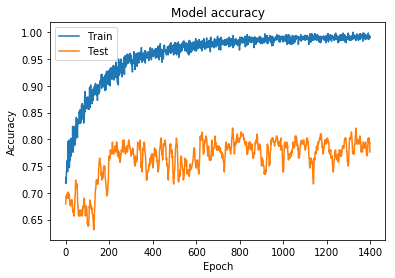

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Train and test on GT_split 2

In [11]:
Train = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 270/270 [00:01<00:00, 194.58it/s]


In [12]:
# Re-initialize weights, since training and testing data switch
LDT_Net = build_LDT_Net(C)

In [13]:
from keras.callbacks import ModelCheckpoint
import keras
lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
'''
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
'''
# checkpoint 报存最好的模型
filepath="weights.GT2best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1400,
                    verbose=True,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 658 samples, validate on 270 samples
Epoch 1/800
658/658 [==============================] - 4s 6ms/step - loss: 4.4273 - acc: 0.0380 - val_loss: 3.6145 - val_acc: 0.0333
Epoch 2/800
658/658 [==============================] - 0s 95us/step - loss: 4.1731 - acc: 0.0304 - val_loss: 3.4619 - val_acc: 0.0333
Epoch 3/800
658/658 [==============================] - 0s 80us/step - loss: 3.9975 - acc: 0.0410 - val_loss: 3.3174 - val_acc: 0.0333
Epoch 4/800
658/658 [==============================] - 0s 82us/step - loss: 3.7999 - acc: 0.0441 - val_loss: 3.1842 - val_acc: 0.0370
Epoch 5/800
658/658 [==============================] - 0s 91us/step - loss: 3.5951 - acc: 0.0547 - val_loss: 3.0625 - val_acc: 0.0519
Epoch 6/800
658/658 [==============================] - 0s 93us/step - loss: 3.5325 - acc: 0.0426 - val_loss: 2.9515 - val_acc: 0.0667
Epoch 7/800
658/658 [==============================] - 0s 96us/step - loss: 3.2711 - acc: 0.0942 - val_loss: 2.8514 - val_acc: 0.1185
Epoch 8/800
658/6

Epoch 62/800
658/658 [==============================] - 0s 87us/step - loss: 1.3847 - acc: 0.5927 - val_loss: 1.4048 - val_acc: 0.5778
Epoch 63/800
658/658 [==============================] - 0s 99us/step - loss: 1.3818 - acc: 0.5973 - val_loss: 1.3970 - val_acc: 0.5815
Epoch 64/800
658/658 [==============================] - 0s 92us/step - loss: 1.3547 - acc: 0.5699 - val_loss: 1.3887 - val_acc: 0.5815
Epoch 65/800
658/658 [==============================] - 0s 92us/step - loss: 1.3502 - acc: 0.5669 - val_loss: 1.3795 - val_acc: 0.5815
Epoch 66/800
658/658 [==============================] - 0s 97us/step - loss: 1.3282 - acc: 0.5851 - val_loss: 1.3705 - val_acc: 0.5852
Epoch 67/800
658/658 [==============================] - 0s 94us/step - loss: 1.3285 - acc: 0.6155 - val_loss: 1.3619 - val_acc: 0.5852
Epoch 68/800
658/658 [==============================] - 0s 83us/step - loss: 1.3144 - acc: 0.5805 - val_loss: 1.3547 - val_acc: 0.5889
Epoch 69/800
658/658 [==============================] -

Epoch 123/800
658/658 [==============================] - 0s 84us/step - loss: 0.9252 - acc: 0.7021 - val_loss: 1.1208 - val_acc: 0.6556
Epoch 124/800
658/658 [==============================] - 0s 87us/step - loss: 0.9519 - acc: 0.7097 - val_loss: 1.1185 - val_acc: 0.6556
Epoch 125/800
658/658 [==============================] - 0s 88us/step - loss: 0.9422 - acc: 0.7234 - val_loss: 1.1162 - val_acc: 0.6556
Epoch 126/800
658/658 [==============================] - 0s 89us/step - loss: 0.9197 - acc: 0.7204 - val_loss: 1.1146 - val_acc: 0.6556
Epoch 127/800
658/658 [==============================] - 0s 88us/step - loss: 0.9255 - acc: 0.7219 - val_loss: 1.1134 - val_acc: 0.6556
Epoch 128/800
658/658 [==============================] - 0s 93us/step - loss: 0.9560 - acc: 0.7021 - val_loss: 1.1122 - val_acc: 0.6556
Epoch 129/800
658/658 [==============================] - 0s 93us/step - loss: 0.8753 - acc: 0.7371 - val_loss: 1.1106 - val_acc: 0.6556
Epoch 130/800
658/658 [=========================

Epoch 184/800
658/658 [==============================] - 0s 86us/step - loss: 0.8814 - acc: 0.7173 - val_loss: 1.0645 - val_acc: 0.6630
Epoch 185/800
658/658 [==============================] - 0s 90us/step - loss: 0.8901 - acc: 0.7310 - val_loss: 1.0643 - val_acc: 0.6667
Epoch 186/800
658/658 [==============================] - 0s 92us/step - loss: 0.8820 - acc: 0.7371 - val_loss: 1.0642 - val_acc: 0.6667
Epoch 187/800
658/658 [==============================] - 0s 82us/step - loss: 0.9165 - acc: 0.7188 - val_loss: 1.0641 - val_acc: 0.6667
Epoch 188/800
658/658 [==============================] - 0s 93us/step - loss: 0.8968 - acc: 0.7128 - val_loss: 1.0639 - val_acc: 0.6667
Epoch 189/800
658/658 [==============================] - 0s 89us/step - loss: 0.8859 - acc: 0.7219 - val_loss: 1.0638 - val_acc: 0.6667
Epoch 190/800
658/658 [==============================] - 0s 85us/step - loss: 0.9278 - acc: 0.7082 - val_loss: 1.0636 - val_acc: 0.6667
Epoch 191/800
658/658 [=========================

Epoch 245/800
658/658 [==============================] - 0s 85us/step - loss: 0.9025 - acc: 0.7204 - val_loss: 1.0628 - val_acc: 0.6630
Epoch 246/800
658/658 [==============================] - 0s 85us/step - loss: 0.9320 - acc: 0.6976 - val_loss: 1.0628 - val_acc: 0.6630
Epoch 247/800
658/658 [==============================] - 0s 90us/step - loss: 0.9148 - acc: 0.7067 - val_loss: 1.0630 - val_acc: 0.6630
Epoch 248/800
658/658 [==============================] - 0s 99us/step - loss: 0.9175 - acc: 0.7112 - val_loss: 1.0630 - val_acc: 0.6630
Epoch 249/800
658/658 [==============================] - 0s 99us/step - loss: 0.9318 - acc: 0.7295 - val_loss: 1.0630 - val_acc: 0.6630
Epoch 250/800
658/658 [==============================] - 0s 85us/step - loss: 0.8689 - acc: 0.7173 - val_loss: 1.0630 - val_acc: 0.6630
Epoch 251/800
658/658 [==============================] - 0s 95us/step - loss: 0.8904 - acc: 0.7234 - val_loss: 1.0631 - val_acc: 0.6630
Epoch 252/800
658/658 [=========================

Epoch 306/800
658/658 [==============================] - 0s 89us/step - loss: 0.8726 - acc: 0.7188 - val_loss: 1.0669 - val_acc: 0.6667
Epoch 307/800
658/658 [==============================] - 0s 90us/step - loss: 0.9006 - acc: 0.7325 - val_loss: 1.0670 - val_acc: 0.6667
Epoch 308/800
658/658 [==============================] - 0s 95us/step - loss: 0.9065 - acc: 0.7234 - val_loss: 1.0670 - val_acc: 0.6667
Epoch 309/800
658/658 [==============================] - 0s 96us/step - loss: 0.8908 - acc: 0.7280 - val_loss: 1.0671 - val_acc: 0.6667
Epoch 310/800
658/658 [==============================] - 0s 84us/step - loss: 0.8640 - acc: 0.7204 - val_loss: 1.0670 - val_acc: 0.6704
Epoch 311/800
658/658 [==============================] - 0s 90us/step - loss: 0.9116 - acc: 0.7249 - val_loss: 1.0671 - val_acc: 0.6741
Epoch 312/800
658/658 [==============================] - 0s 93us/step - loss: 0.8893 - acc: 0.7204 - val_loss: 1.0672 - val_acc: 0.6741
Epoch 313/800
658/658 [=========================

Epoch 367/800
658/658 [==============================] - 0s 91us/step - loss: 0.9033 - acc: 0.7280 - val_loss: 1.0682 - val_acc: 0.6630
Epoch 368/800
658/658 [==============================] - 0s 96us/step - loss: 0.8750 - acc: 0.7158 - val_loss: 1.0682 - val_acc: 0.6630
Epoch 369/800
658/658 [==============================] - 0s 95us/step - loss: 0.8639 - acc: 0.7249 - val_loss: 1.0682 - val_acc: 0.6630
Epoch 370/800
658/658 [==============================] - 0s 90us/step - loss: 0.9003 - acc: 0.7052 - val_loss: 1.0681 - val_acc: 0.6630
Epoch 371/800
658/658 [==============================] - 0s 92us/step - loss: 0.9324 - acc: 0.7158 - val_loss: 1.0681 - val_acc: 0.6630
Epoch 372/800
658/658 [==============================] - 0s 86us/step - loss: 0.9395 - acc: 0.7128 - val_loss: 1.0681 - val_acc: 0.6630
Epoch 373/800
658/658 [==============================] - 0s 94us/step - loss: 0.9147 - acc: 0.7052 - val_loss: 1.0682 - val_acc: 0.6630
Epoch 374/800
658/658 [=========================

Epoch 428/800
658/658 [==============================] - 0s 87us/step - loss: 0.8573 - acc: 0.7158 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 429/800
658/658 [==============================] - 0s 96us/step - loss: 0.8879 - acc: 0.7173 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 430/800
658/658 [==============================] - 0s 89us/step - loss: 0.8795 - acc: 0.7310 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 431/800
658/658 [==============================] - 0s 89us/step - loss: 0.8872 - acc: 0.7204 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 432/800
658/658 [==============================] - 0s 89us/step - loss: 0.8961 - acc: 0.7112 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 433/800
658/658 [==============================] - 0s 98us/step - loss: 0.8490 - acc: 0.7249 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 434/800
658/658 [==============================] - 0s 87us/step - loss: 0.8626 - acc: 0.7508 - val_loss: 1.0687 - val_acc: 0.6630
Epoch 435/800
658/658 [=========================

Epoch 489/800
658/658 [==============================] - 0s 86us/step - loss: 0.8234 - acc: 0.7310 - val_loss: 1.0679 - val_acc: 0.6667
Epoch 490/800
658/658 [==============================] - 0s 86us/step - loss: 0.8267 - acc: 0.7447 - val_loss: 1.0680 - val_acc: 0.6667
Epoch 491/800
658/658 [==============================] - 0s 90us/step - loss: 0.8565 - acc: 0.7280 - val_loss: 1.0681 - val_acc: 0.6667
Epoch 492/800
658/658 [==============================] - 0s 90us/step - loss: 0.8870 - acc: 0.7112 - val_loss: 1.0681 - val_acc: 0.6704
Epoch 493/800
658/658 [==============================] - 0s 88us/step - loss: 0.8590 - acc: 0.7280 - val_loss: 1.0681 - val_acc: 0.6704
Epoch 494/800
658/658 [==============================] - 0s 88us/step - loss: 0.8795 - acc: 0.7432 - val_loss: 1.0680 - val_acc: 0.6704
Epoch 495/800
658/658 [==============================] - 0s 88us/step - loss: 0.8810 - acc: 0.7204 - val_loss: 1.0681 - val_acc: 0.6704
Epoch 496/800
658/658 [=========================

Epoch 550/800
658/658 [==============================] - 0s 85us/step - loss: 0.8751 - acc: 0.7097 - val_loss: 1.0672 - val_acc: 0.6704
Epoch 551/800
658/658 [==============================] - 0s 80us/step - loss: 0.8556 - acc: 0.7386 - val_loss: 1.0672 - val_acc: 0.6704
Epoch 552/800
658/658 [==============================] - 0s 96us/step - loss: 0.9130 - acc: 0.7234 - val_loss: 1.0671 - val_acc: 0.6704
Epoch 553/800
658/658 [==============================] - 0s 95us/step - loss: 0.8657 - acc: 0.7371 - val_loss: 1.0670 - val_acc: 0.6704
Epoch 554/800
658/658 [==============================] - 0s 94us/step - loss: 0.8723 - acc: 0.7325 - val_loss: 1.0670 - val_acc: 0.6704
Epoch 555/800
658/658 [==============================] - 0s 95us/step - loss: 0.8584 - acc: 0.7219 - val_loss: 1.0669 - val_acc: 0.6704
Epoch 556/800
658/658 [==============================] - 0s 87us/step - loss: 0.8738 - acc: 0.7188 - val_loss: 1.0670 - val_acc: 0.6704
Epoch 557/800
658/658 [=========================

Epoch 611/800
658/658 [==============================] - 0s 91us/step - loss: 0.8530 - acc: 0.7401 - val_loss: 1.0646 - val_acc: 0.6667
Epoch 612/800
658/658 [==============================] - 0s 91us/step - loss: 0.8735 - acc: 0.7219 - val_loss: 1.0646 - val_acc: 0.6667
Epoch 613/800
658/658 [==============================] - 0s 99us/step - loss: 0.8361 - acc: 0.7371 - val_loss: 1.0645 - val_acc: 0.6667
Epoch 614/800
658/658 [==============================] - 0s 94us/step - loss: 0.8872 - acc: 0.7219 - val_loss: 1.0644 - val_acc: 0.6667
Epoch 615/800
658/658 [==============================] - 0s 92us/step - loss: 0.8584 - acc: 0.7280 - val_loss: 1.0644 - val_acc: 0.6667
Epoch 616/800
658/658 [==============================] - 0s 92us/step - loss: 0.8911 - acc: 0.7188 - val_loss: 1.0643 - val_acc: 0.6667
Epoch 617/800
658/658 [==============================] - 0s 89us/step - loss: 0.8575 - acc: 0.7447 - val_loss: 1.0642 - val_acc: 0.6667
Epoch 618/800
658/658 [=========================

Epoch 672/800
658/658 [==============================] - 0s 86us/step - loss: 0.8642 - acc: 0.7462 - val_loss: 1.0619 - val_acc: 0.6667
Epoch 673/800
658/658 [==============================] - 0s 81us/step - loss: 0.8904 - acc: 0.7280 - val_loss: 1.0618 - val_acc: 0.6667
Epoch 674/800
658/658 [==============================] - 0s 97us/step - loss: 0.8683 - acc: 0.7264 - val_loss: 1.0618 - val_acc: 0.6667
Epoch 675/800
658/658 [==============================] - 0s 88us/step - loss: 0.8626 - acc: 0.7340 - val_loss: 1.0618 - val_acc: 0.6667
Epoch 676/800
658/658 [==============================] - 0s 92us/step - loss: 0.9016 - acc: 0.7112 - val_loss: 1.0617 - val_acc: 0.6667
Epoch 677/800
658/658 [==============================] - 0s 88us/step - loss: 0.8538 - acc: 0.7173 - val_loss: 1.0617 - val_acc: 0.6667
Epoch 678/800
658/658 [==============================] - 0s 92us/step - loss: 0.8899 - acc: 0.7173 - val_loss: 1.0616 - val_acc: 0.6667
Epoch 679/800
658/658 [=========================

Epoch 733/800
658/658 [==============================] - 0s 94us/step - loss: 0.8709 - acc: 0.7340 - val_loss: 1.0601 - val_acc: 0.6630
Epoch 734/800
658/658 [==============================] - 0s 91us/step - loss: 0.8746 - acc: 0.7006 - val_loss: 1.0601 - val_acc: 0.6630
Epoch 735/800
658/658 [==============================] - 0s 90us/step - loss: 0.8809 - acc: 0.7280 - val_loss: 1.0600 - val_acc: 0.6630
Epoch 736/800
658/658 [==============================] - 0s 90us/step - loss: 0.8840 - acc: 0.7128 - val_loss: 1.0600 - val_acc: 0.6630
Epoch 737/800
658/658 [==============================] - 0s 80us/step - loss: 0.8774 - acc: 0.7249 - val_loss: 1.0600 - val_acc: 0.6630
Epoch 738/800
658/658 [==============================] - 0s 93us/step - loss: 0.8585 - acc: 0.7386 - val_loss: 1.0600 - val_acc: 0.6630
Epoch 739/800
658/658 [==============================] - 0s 91us/step - loss: 0.8441 - acc: 0.7371 - val_loss: 1.0600 - val_acc: 0.6630
Epoch 740/800
658/658 [=========================

Epoch 794/800
658/658 [==============================] - 0s 86us/step - loss: 0.8851 - acc: 0.7173 - val_loss: 1.0580 - val_acc: 0.6667
Epoch 795/800
658/658 [==============================] - 0s 87us/step - loss: 0.8565 - acc: 0.7462 - val_loss: 1.0580 - val_acc: 0.6667
Epoch 796/800
658/658 [==============================] - 0s 88us/step - loss: 0.8338 - acc: 0.7584 - val_loss: 1.0579 - val_acc: 0.6667
Epoch 797/800
658/658 [==============================] - 0s 95us/step - loss: 0.8791 - acc: 0.7340 - val_loss: 1.0578 - val_acc: 0.6667
Epoch 798/800
658/658 [==============================] - 0s 89us/step - loss: 0.8704 - acc: 0.7280 - val_loss: 1.0578 - val_acc: 0.6667
Epoch 799/800
658/658 [==============================] - 0s 87us/step - loss: 0.8432 - acc: 0.7325 - val_loss: 1.0578 - val_acc: 0.6667
Epoch 800/800
658/658 [==============================] - 0s 90us/step - loss: 0.8173 - acc: 0.7386 - val_loss: 1.0578 - val_acc: 0.6667
Train on 658 samples, validate on 270 samples
Ep


Epoch 00041: val_acc did not improve
Epoch 42/1400
658/658 [==============================] - 0s 86us/step - loss: 0.6492 - acc: 0.7964 - val_loss: 1.0143 - val_acc: 0.6667

Epoch 00042: val_acc did not improve
Epoch 43/1400
658/658 [==============================] - 0s 94us/step - loss: 0.6490 - acc: 0.8009 - val_loss: 1.0166 - val_acc: 0.6667

Epoch 00043: val_acc did not improve
Epoch 44/1400
658/658 [==============================] - 0s 92us/step - loss: 0.6547 - acc: 0.7964 - val_loss: 1.0166 - val_acc: 0.6704

Epoch 00044: val_acc did not improve
Epoch 45/1400
658/658 [==============================] - 0s 84us/step - loss: 0.6039 - acc: 0.8055 - val_loss: 1.0151 - val_acc: 0.6704

Epoch 00045: val_acc did not improve
Epoch 46/1400
658/658 [==============================] - 0s 91us/step - loss: 0.6011 - acc: 0.8085 - val_loss: 1.0160 - val_acc: 0.6741

Epoch 00046: val_acc did not improve
Epoch 47/1400
658/658 [==============================] - 0s 94us/step - loss: 0.6032 - acc: 


Epoch 00088: val_acc did not improve
Epoch 89/1400
658/658 [==============================] - 0s 87us/step - loss: 0.4668 - acc: 0.8663 - val_loss: 1.0833 - val_acc: 0.6519

Epoch 00089: val_acc did not improve
Epoch 90/1400
658/658 [==============================] - 0s 90us/step - loss: 0.4664 - acc: 0.8480 - val_loss: 1.0875 - val_acc: 0.6407

Epoch 00090: val_acc did not improve
Epoch 91/1400
658/658 [==============================] - 0s 88us/step - loss: 0.4874 - acc: 0.8435 - val_loss: 1.0918 - val_acc: 0.6407

Epoch 00091: val_acc did not improve
Epoch 92/1400
658/658 [==============================] - 0s 91us/step - loss: 0.5237 - acc: 0.8237 - val_loss: 1.0980 - val_acc: 0.6481

Epoch 00092: val_acc did not improve
Epoch 93/1400
658/658 [==============================] - 0s 91us/step - loss: 0.4894 - acc: 0.8374 - val_loss: 1.1019 - val_acc: 0.6519

Epoch 00093: val_acc did not improve
Epoch 94/1400
658/658 [==============================] - 0s 91us/step - loss: 0.4878 - acc: 


Epoch 00135: val_acc did not improve
Epoch 136/1400
658/658 [==============================] - 0s 95us/step - loss: 0.4132 - acc: 0.8602 - val_loss: 1.0887 - val_acc: 0.6519

Epoch 00136: val_acc did not improve
Epoch 137/1400
658/658 [==============================] - 0s 102us/step - loss: 0.3923 - acc: 0.8708 - val_loss: 1.0806 - val_acc: 0.6519

Epoch 00137: val_acc did not improve
Epoch 138/1400
658/658 [==============================] - 0s 88us/step - loss: 0.3872 - acc: 0.8739 - val_loss: 1.0746 - val_acc: 0.6556

Epoch 00138: val_acc did not improve
Epoch 139/1400
658/658 [==============================] - 0s 83us/step - loss: 0.3636 - acc: 0.8982 - val_loss: 1.0732 - val_acc: 0.6519

Epoch 00139: val_acc did not improve
Epoch 140/1400
658/658 [==============================] - 0s 94us/step - loss: 0.3323 - acc: 0.9073 - val_loss: 1.0719 - val_acc: 0.6630

Epoch 00140: val_acc did not improve
Epoch 141/1400
658/658 [==============================] - 0s 92us/step - loss: 0.3971 

Epoch 182/1400
658/658 [==============================] - 0s 90us/step - loss: 0.3503 - acc: 0.8921 - val_loss: 1.0303 - val_acc: 0.6926

Epoch 00182: val_acc did not improve
Epoch 183/1400
658/658 [==============================] - 0s 97us/step - loss: 0.2884 - acc: 0.9119 - val_loss: 1.0400 - val_acc: 0.6852

Epoch 00183: val_acc did not improve
Epoch 184/1400
658/658 [==============================] - 0s 92us/step - loss: 0.3003 - acc: 0.9149 - val_loss: 1.0475 - val_acc: 0.6852

Epoch 00184: val_acc did not improve
Epoch 185/1400
658/658 [==============================] - 0s 88us/step - loss: 0.3377 - acc: 0.8997 - val_loss: 1.0560 - val_acc: 0.6815

Epoch 00185: val_acc did not improve
Epoch 186/1400
658/658 [==============================] - 0s 80us/step - loss: 0.2771 - acc: 0.9149 - val_loss: 1.0626 - val_acc: 0.6741

Epoch 00186: val_acc did not improve
Epoch 187/1400
658/658 [==============================] - 0s 91us/step - loss: 0.3494 - acc: 0.8982 - val_loss: 1.0674 - val_

658/658 [==============================] - 0s 95us/step - loss: 0.2443 - acc: 0.9407 - val_loss: 1.1948 - val_acc: 0.6630

Epoch 00229: val_acc did not improve
Epoch 230/1400
658/658 [==============================] - 0s 99us/step - loss: 0.2395 - acc: 0.9240 - val_loss: 1.1757 - val_acc: 0.6667

Epoch 00230: val_acc did not improve
Epoch 231/1400
658/658 [==============================] - 0s 92us/step - loss: 0.2529 - acc: 0.9134 - val_loss: 1.1585 - val_acc: 0.6630

Epoch 00231: val_acc did not improve
Epoch 232/1400
658/658 [==============================] - 0s 95us/step - loss: 0.2247 - acc: 0.9347 - val_loss: 1.1376 - val_acc: 0.6667

Epoch 00232: val_acc did not improve
Epoch 233/1400
658/658 [==============================] - 0s 96us/step - loss: 0.2464 - acc: 0.9255 - val_loss: 1.1193 - val_acc: 0.6741

Epoch 00233: val_acc did not improve
Epoch 234/1400
658/658 [==============================] - 0s 85us/step - loss: 0.2540 - acc: 0.9271 - val_loss: 1.1043 - val_acc: 0.6778

Ep


Epoch 00275: val_acc did not improve
Epoch 276/1400
658/658 [==============================] - 0s 87us/step - loss: 0.2012 - acc: 0.9438 - val_loss: 1.1278 - val_acc: 0.6926

Epoch 00276: val_acc did not improve
Epoch 277/1400
658/658 [==============================] - 0s 82us/step - loss: 0.1896 - acc: 0.9514 - val_loss: 1.1455 - val_acc: 0.6889

Epoch 00277: val_acc did not improve
Epoch 278/1400
658/658 [==============================] - 0s 87us/step - loss: 0.1792 - acc: 0.9483 - val_loss: 1.1551 - val_acc: 0.6852

Epoch 00278: val_acc did not improve
Epoch 279/1400
658/658 [==============================] - 0s 93us/step - loss: 0.2198 - acc: 0.9377 - val_loss: 1.1655 - val_acc: 0.6815

Epoch 00279: val_acc did not improve
Epoch 280/1400
658/658 [==============================] - 0s 93us/step - loss: 0.1995 - acc: 0.9438 - val_loss: 1.1721 - val_acc: 0.6815

Epoch 00280: val_acc did not improve
Epoch 281/1400
658/658 [==============================] - 0s 82us/step - loss: 0.2378 -

658/658 [==============================] - 0s 92us/step - loss: 0.1570 - acc: 0.9529 - val_loss: 1.1765 - val_acc: 0.6815

Epoch 00322: val_acc did not improve
Epoch 323/1400
658/658 [==============================] - 0s 91us/step - loss: 0.1798 - acc: 0.9362 - val_loss: 1.1572 - val_acc: 0.6815

Epoch 00323: val_acc did not improve
Epoch 324/1400
658/658 [==============================] - 0s 99us/step - loss: 0.1843 - acc: 0.9514 - val_loss: 1.1360 - val_acc: 0.6926

Epoch 00324: val_acc did not improve
Epoch 325/1400
658/658 [==============================] - 0s 92us/step - loss: 0.1918 - acc: 0.9453 - val_loss: 1.1173 - val_acc: 0.7037

Epoch 00325: val_acc did not improve
Epoch 326/1400
658/658 [==============================] - 0s 84us/step - loss: 0.1845 - acc: 0.9620 - val_loss: 1.0972 - val_acc: 0.7222

Epoch 00326: val_acc improved from 0.71481 to 0.72222, saving model to weights.GT2best.hdf5
Epoch 327/1400
658/658 [==============================] - 0s 93us/step - loss: 0.1652


Epoch 00366: val_acc did not improve
Epoch 367/1400
658/658 [==============================] - 0s 89us/step - loss: 0.1879 - acc: 0.9468 - val_loss: 1.0768 - val_acc: 0.7296

Epoch 00367: val_acc did not improve
Epoch 368/1400
658/658 [==============================] - 0s 87us/step - loss: 0.1938 - acc: 0.9422 - val_loss: 1.0799 - val_acc: 0.7259

Epoch 00368: val_acc did not improve
Epoch 369/1400
658/658 [==============================] - 0s 89us/step - loss: 0.1644 - acc: 0.9514 - val_loss: 1.0810 - val_acc: 0.7148

Epoch 00369: val_acc did not improve
Epoch 370/1400
658/658 [==============================] - 0s 88us/step - loss: 0.1664 - acc: 0.9559 - val_loss: 1.0818 - val_acc: 0.7148

Epoch 00370: val_acc did not improve
Epoch 371/1400
658/658 [==============================] - 0s 83us/step - loss: 0.1697 - acc: 0.9407 - val_loss: 1.0659 - val_acc: 0.7185

Epoch 00371: val_acc did not improve
Epoch 372/1400
658/658 [==============================] - 0s 96us/step - loss: 0.1300 -


Epoch 00413: val_acc did not improve
Epoch 414/1400
658/658 [==============================] - 0s 84us/step - loss: 0.1387 - acc: 0.9574 - val_loss: 1.0464 - val_acc: 0.7333

Epoch 00414: val_acc did not improve
Epoch 415/1400
658/658 [==============================] - 0s 98us/step - loss: 0.1430 - acc: 0.9544 - val_loss: 1.0474 - val_acc: 0.7370

Epoch 00415: val_acc did not improve
Epoch 416/1400
658/658 [==============================] - 0s 84us/step - loss: 0.1207 - acc: 0.9635 - val_loss: 1.0539 - val_acc: 0.7333

Epoch 00416: val_acc did not improve
Epoch 417/1400
658/658 [==============================] - 0s 95us/step - loss: 0.1435 - acc: 0.9574 - val_loss: 1.0641 - val_acc: 0.7333

Epoch 00417: val_acc did not improve
Epoch 418/1400
658/658 [==============================] - 0s 91us/step - loss: 0.1157 - acc: 0.9696 - val_loss: 1.0688 - val_acc: 0.7296

Epoch 00418: val_acc did not improve
Epoch 419/1400
658/658 [==============================] - 0s 91us/step - loss: 0.1566 -


Epoch 00460: val_acc did not improve
Epoch 461/1400
658/658 [==============================] - 0s 91us/step - loss: 0.1199 - acc: 0.9650 - val_loss: 1.1073 - val_acc: 0.7074

Epoch 00461: val_acc did not improve
Epoch 462/1400
658/658 [==============================] - 0s 88us/step - loss: 0.1066 - acc: 0.9711 - val_loss: 1.1135 - val_acc: 0.7074

Epoch 00462: val_acc did not improve
Epoch 463/1400
658/658 [==============================] - 0s 94us/step - loss: 0.1223 - acc: 0.9681 - val_loss: 1.1108 - val_acc: 0.7074

Epoch 00463: val_acc did not improve
Epoch 464/1400
658/658 [==============================] - 0s 84us/step - loss: 0.1175 - acc: 0.9635 - val_loss: 1.1039 - val_acc: 0.7148

Epoch 00464: val_acc did not improve
Epoch 465/1400
658/658 [==============================] - 0s 94us/step - loss: 0.1019 - acc: 0.9742 - val_loss: 1.0990 - val_acc: 0.7259

Epoch 00465: val_acc did not improve
Epoch 466/1400
658/658 [==============================] - 0s 87us/step - loss: 0.1065 -


Epoch 00507: val_acc did not improve
Epoch 508/1400
658/658 [==============================] - 0s 92us/step - loss: 0.1016 - acc: 0.9696 - val_loss: 1.0132 - val_acc: 0.7407

Epoch 00508: val_acc did not improve
Epoch 509/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0998 - acc: 0.9666 - val_loss: 1.0157 - val_acc: 0.7407

Epoch 00509: val_acc did not improve
Epoch 510/1400
658/658 [==============================] - 0s 102us/step - loss: 0.0954 - acc: 0.9742 - val_loss: 1.0270 - val_acc: 0.7370

Epoch 00510: val_acc did not improve
Epoch 511/1400
658/658 [==============================] - 0s 90us/step - loss: 0.1019 - acc: 0.9818 - val_loss: 1.0405 - val_acc: 0.7296

Epoch 00511: val_acc did not improve
Epoch 512/1400
658/658 [==============================] - 0s 93us/step - loss: 0.1177 - acc: 0.9620 - val_loss: 1.0605 - val_acc: 0.7259

Epoch 00512: val_acc did not improve
Epoch 513/1400
658/658 [==============================] - 0s 99us/step - loss: 0.0851 


Epoch 00554: val_acc did not improve
Epoch 555/1400
658/658 [==============================] - 0s 90us/step - loss: 0.1451 - acc: 0.9590 - val_loss: 1.0492 - val_acc: 0.7407

Epoch 00555: val_acc did not improve
Epoch 556/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0849 - acc: 0.9757 - val_loss: 1.0373 - val_acc: 0.7370

Epoch 00556: val_acc did not improve
Epoch 557/1400
658/658 [==============================] - 0s 82us/step - loss: 0.0867 - acc: 0.9818 - val_loss: 1.0224 - val_acc: 0.7444

Epoch 00557: val_acc did not improve
Epoch 558/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0788 - acc: 0.9742 - val_loss: 1.0130 - val_acc: 0.7519

Epoch 00558: val_acc did not improve
Epoch 559/1400
658/658 [==============================] - 0s 98us/step - loss: 0.0939 - acc: 0.9726 - val_loss: 1.0121 - val_acc: 0.7556

Epoch 00559: val_acc did not improve
Epoch 560/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0953 -


Epoch 00601: val_acc did not improve
Epoch 602/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0744 - acc: 0.9833 - val_loss: 1.0426 - val_acc: 0.7519

Epoch 00602: val_acc did not improve
Epoch 603/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0760 - acc: 0.9772 - val_loss: 1.0375 - val_acc: 0.7481

Epoch 00603: val_acc did not improve
Epoch 604/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0773 - acc: 0.9833 - val_loss: 1.0403 - val_acc: 0.7519

Epoch 00604: val_acc did not improve
Epoch 605/1400
658/658 [==============================] - 0s 97us/step - loss: 0.0861 - acc: 0.9772 - val_loss: 1.0433 - val_acc: 0.7519

Epoch 00605: val_acc did not improve
Epoch 606/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0910 - acc: 0.9802 - val_loss: 1.0468 - val_acc: 0.7481

Epoch 00606: val_acc did not improve
Epoch 607/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0699 -


Epoch 00648: val_acc did not improve
Epoch 649/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0786 - acc: 0.9757 - val_loss: 1.0503 - val_acc: 0.7296

Epoch 00649: val_acc did not improve
Epoch 650/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0844 - acc: 0.9757 - val_loss: 1.0506 - val_acc: 0.7259

Epoch 00650: val_acc did not improve
Epoch 651/1400
658/658 [==============================] - 0s 88us/step - loss: 0.0809 - acc: 0.9772 - val_loss: 1.0495 - val_acc: 0.7370

Epoch 00651: val_acc did not improve
Epoch 652/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0748 - acc: 0.9787 - val_loss: 1.0514 - val_acc: 0.7370

Epoch 00652: val_acc did not improve
Epoch 653/1400
658/658 [==============================] - 0s 100us/step - loss: 0.0854 - acc: 0.9802 - val_loss: 1.0548 - val_acc: 0.7333

Epoch 00653: val_acc did not improve
Epoch 654/1400
658/658 [==============================] - 0s 98us/step - loss: 0.0785 


Epoch 00695: val_acc did not improve
Epoch 696/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0871 - acc: 0.9787 - val_loss: 1.1664 - val_acc: 0.7185

Epoch 00696: val_acc did not improve
Epoch 697/1400
658/658 [==============================] - 0s 100us/step - loss: 0.0833 - acc: 0.9787 - val_loss: 1.1685 - val_acc: 0.7148

Epoch 00697: val_acc did not improve
Epoch 698/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0668 - acc: 0.9833 - val_loss: 1.1688 - val_acc: 0.7148

Epoch 00698: val_acc did not improve
Epoch 699/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0689 - acc: 0.9772 - val_loss: 1.1696 - val_acc: 0.7148

Epoch 00699: val_acc did not improve
Epoch 700/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0757 - acc: 0.9787 - val_loss: 1.1714 - val_acc: 0.7148

Epoch 00700: val_acc did not improve
Epoch 701/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0952 


Epoch 00742: val_acc did not improve
Epoch 743/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0601 - acc: 0.9818 - val_loss: 1.1896 - val_acc: 0.7444

Epoch 00743: val_acc did not improve
Epoch 744/1400
658/658 [==============================] - 0s 99us/step - loss: 0.0653 - acc: 0.9742 - val_loss: 1.1900 - val_acc: 0.7444

Epoch 00744: val_acc did not improve
Epoch 745/1400
658/658 [==============================] - 0s 93us/step - loss: 0.0924 - acc: 0.9726 - val_loss: 1.1847 - val_acc: 0.7370

Epoch 00745: val_acc did not improve
Epoch 746/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0558 - acc: 0.9924 - val_loss: 1.1766 - val_acc: 0.7333

Epoch 00746: val_acc did not improve
Epoch 747/1400
658/658 [==============================] - 0s 101us/step - loss: 0.0759 - acc: 0.9772 - val_loss: 1.1754 - val_acc: 0.7370

Epoch 00747: val_acc did not improve
Epoch 748/1400
658/658 [==============================] - 0s 93us/step - loss: 0.0646 


Epoch 00789: val_acc improved from 0.76296 to 0.77037, saving model to weights.GT2best.hdf5
Epoch 790/1400
658/658 [==============================] - 0s 83us/step - loss: 0.0765 - acc: 0.9757 - val_loss: 1.0269 - val_acc: 0.7704

Epoch 00790: val_acc did not improve
Epoch 791/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0738 - acc: 0.9696 - val_loss: 1.0258 - val_acc: 0.7704

Epoch 00791: val_acc did not improve
Epoch 792/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0507 - acc: 0.9863 - val_loss: 1.0321 - val_acc: 0.7630

Epoch 00792: val_acc did not improve
Epoch 793/1400
658/658 [==============================] - 0s 83us/step - loss: 0.0705 - acc: 0.9787 - val_loss: 1.0435 - val_acc: 0.7593

Epoch 00793: val_acc did not improve
Epoch 794/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0639 - acc: 0.9802 - val_loss: 1.0546 - val_acc: 0.7519

Epoch 00794: val_acc did not improve
Epoch 795/1400
658/658 [========


Epoch 00836: val_acc did not improve
Epoch 837/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0601 - acc: 0.9848 - val_loss: 1.1602 - val_acc: 0.7296

Epoch 00837: val_acc did not improve
Epoch 838/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0611 - acc: 0.9802 - val_loss: 1.1532 - val_acc: 0.7259

Epoch 00838: val_acc did not improve
Epoch 839/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0531 - acc: 0.9833 - val_loss: 1.1447 - val_acc: 0.7296

Epoch 00839: val_acc did not improve
Epoch 840/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0545 - acc: 0.9924 - val_loss: 1.1400 - val_acc: 0.7259

Epoch 00840: val_acc did not improve
Epoch 841/1400
658/658 [==============================] - 0s 81us/step - loss: 0.0493 - acc: 0.9924 - val_loss: 1.1400 - val_acc: 0.7222

Epoch 00841: val_acc did not improve
Epoch 842/1400
658/658 [==============================] - 0s 84us/step - loss: 0.0579 -


Epoch 00883: val_acc did not improve
Epoch 884/1400
658/658 [==============================] - 0s 93us/step - loss: 0.0428 - acc: 0.9863 - val_loss: 1.0802 - val_acc: 0.7370

Epoch 00884: val_acc did not improve
Epoch 885/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0423 - acc: 0.9863 - val_loss: 1.0923 - val_acc: 0.7333

Epoch 00885: val_acc did not improve
Epoch 886/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0504 - acc: 0.9833 - val_loss: 1.1057 - val_acc: 0.7296

Epoch 00886: val_acc did not improve
Epoch 887/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0548 - acc: 0.9848 - val_loss: 1.1133 - val_acc: 0.7296

Epoch 00887: val_acc did not improve
Epoch 888/1400
658/658 [==============================] - 0s 95us/step - loss: 0.0530 - acc: 0.9848 - val_loss: 1.1231 - val_acc: 0.7296

Epoch 00888: val_acc did not improve
Epoch 889/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0413 -


Epoch 00930: val_acc did not improve
Epoch 931/1400
658/658 [==============================] - 0s 99us/step - loss: 0.0393 - acc: 0.9894 - val_loss: 1.1308 - val_acc: 0.7444

Epoch 00931: val_acc did not improve
Epoch 932/1400
658/658 [==============================] - 0s 86us/step - loss: 0.0508 - acc: 0.9878 - val_loss: 1.1243 - val_acc: 0.7519

Epoch 00932: val_acc did not improve
Epoch 933/1400
658/658 [==============================] - 0s 95us/step - loss: 0.0511 - acc: 0.9818 - val_loss: 1.1150 - val_acc: 0.7481

Epoch 00933: val_acc did not improve
Epoch 934/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0616 - acc: 0.9802 - val_loss: 1.0989 - val_acc: 0.7370

Epoch 00934: val_acc did not improve
Epoch 935/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0513 - acc: 0.9863 - val_loss: 1.0927 - val_acc: 0.7407

Epoch 00935: val_acc did not improve
Epoch 936/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0448 -


Epoch 00977: val_acc did not improve
Epoch 978/1400
658/658 [==============================] - 0s 80us/step - loss: 0.0596 - acc: 0.9802 - val_loss: 1.0824 - val_acc: 0.7556

Epoch 00978: val_acc did not improve
Epoch 979/1400
658/658 [==============================] - 0s 96us/step - loss: 0.0408 - acc: 0.9878 - val_loss: 1.0932 - val_acc: 0.7519

Epoch 00979: val_acc did not improve
Epoch 980/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0507 - acc: 0.9878 - val_loss: 1.1035 - val_acc: 0.7556

Epoch 00980: val_acc did not improve
Epoch 981/1400
658/658 [==============================] - 0s 93us/step - loss: 0.0445 - acc: 0.9878 - val_loss: 1.1080 - val_acc: 0.7519

Epoch 00981: val_acc did not improve
Epoch 982/1400
658/658 [==============================] - 0s 97us/step - loss: 0.0528 - acc: 0.9802 - val_loss: 1.1078 - val_acc: 0.7519

Epoch 00982: val_acc did not improve
Epoch 983/1400
658/658 [==============================] - 0s 97us/step - loss: 0.0345 -


Epoch 01024: val_acc did not improve
Epoch 1025/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0424 - acc: 0.9894 - val_loss: 1.1408 - val_acc: 0.7519

Epoch 01025: val_acc did not improve
Epoch 1026/1400
658/658 [==============================] - 0s 86us/step - loss: 0.0403 - acc: 0.9894 - val_loss: 1.1444 - val_acc: 0.7519

Epoch 01026: val_acc did not improve
Epoch 1027/1400
658/658 [==============================] - 0s 95us/step - loss: 0.0629 - acc: 0.9833 - val_loss: 1.1335 - val_acc: 0.7444

Epoch 01027: val_acc did not improve
Epoch 1028/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0530 - acc: 0.9863 - val_loss: 1.1226 - val_acc: 0.7556

Epoch 01028: val_acc did not improve
Epoch 1029/1400
658/658 [==============================] - 0s 88us/step - loss: 0.0536 - acc: 0.9833 - val_loss: 1.1150 - val_acc: 0.7593

Epoch 01029: val_acc did not improve
Epoch 1030/1400
658/658 [==============================] - 0s 93us/step - loss: 0.


Epoch 01071: val_acc did not improve
Epoch 1072/1400
658/658 [==============================] - 0s 94us/step - loss: 0.0509 - acc: 0.9878 - val_loss: 1.2487 - val_acc: 0.7333

Epoch 01072: val_acc did not improve
Epoch 1073/1400
658/658 [==============================] - 0s 83us/step - loss: 0.0406 - acc: 0.9848 - val_loss: 1.2498 - val_acc: 0.7296

Epoch 01073: val_acc did not improve
Epoch 1074/1400
658/658 [==============================] - 0s 95us/step - loss: 0.0559 - acc: 0.9833 - val_loss: 1.2490 - val_acc: 0.7333

Epoch 01074: val_acc did not improve
Epoch 1075/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0370 - acc: 0.9924 - val_loss: 1.2430 - val_acc: 0.7370

Epoch 01075: val_acc did not improve
Epoch 1076/1400
658/658 [==============================] - 0s 86us/step - loss: 0.0334 - acc: 0.9894 - val_loss: 1.2383 - val_acc: 0.7370

Epoch 01076: val_acc did not improve
Epoch 1077/1400
658/658 [==============================] - 0s 90us/step - loss: 0.


Epoch 01118: val_acc did not improve
Epoch 1119/1400
658/658 [==============================] - 0s 95us/step - loss: 0.0445 - acc: 0.9878 - val_loss: 1.1600 - val_acc: 0.7370

Epoch 01119: val_acc did not improve
Epoch 1120/1400
658/658 [==============================] - 0s 83us/step - loss: 0.0372 - acc: 0.9909 - val_loss: 1.1567 - val_acc: 0.7370

Epoch 01120: val_acc did not improve
Epoch 1121/1400
658/658 [==============================] - 0s 98us/step - loss: 0.0367 - acc: 0.9848 - val_loss: 1.1497 - val_acc: 0.7370

Epoch 01121: val_acc did not improve
Epoch 1122/1400
658/658 [==============================] - 0s 83us/step - loss: 0.0346 - acc: 0.9894 - val_loss: 1.1436 - val_acc: 0.7370

Epoch 01122: val_acc did not improve
Epoch 1123/1400
658/658 [==============================] - 0s 94us/step - loss: 0.0348 - acc: 0.9954 - val_loss: 1.1392 - val_acc: 0.7444

Epoch 01123: val_acc did not improve
Epoch 1124/1400
658/658 [==============================] - 0s 89us/step - loss: 0.


Epoch 01165: val_acc did not improve
Epoch 1166/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0331 - acc: 0.9924 - val_loss: 1.2209 - val_acc: 0.7296

Epoch 01166: val_acc did not improve
Epoch 1167/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0333 - acc: 0.9924 - val_loss: 1.2492 - val_acc: 0.7222

Epoch 01167: val_acc did not improve
Epoch 1168/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0280 - acc: 0.9954 - val_loss: 1.2756 - val_acc: 0.7148

Epoch 01168: val_acc did not improve
Epoch 1169/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0451 - acc: 0.9894 - val_loss: 1.2941 - val_acc: 0.7111

Epoch 01169: val_acc did not improve
Epoch 1170/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0271 - acc: 0.9939 - val_loss: 1.3106 - val_acc: 0.7111

Epoch 01170: val_acc did not improve
Epoch 1171/1400
658/658 [==============================] - 0s 93us/step - loss: 0.


Epoch 01212: val_acc did not improve
Epoch 1213/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0442 - acc: 0.9894 - val_loss: 1.0700 - val_acc: 0.7556

Epoch 01213: val_acc did not improve
Epoch 1214/1400
658/658 [==============================] - 0s 98us/step - loss: 0.0342 - acc: 0.9909 - val_loss: 1.0750 - val_acc: 0.7481

Epoch 01214: val_acc did not improve
Epoch 1215/1400
658/658 [==============================] - 0s 84us/step - loss: 0.0581 - acc: 0.9848 - val_loss: 1.0822 - val_acc: 0.7444

Epoch 01215: val_acc did not improve
Epoch 1216/1400
658/658 [==============================] - 0s 90us/step - loss: 0.0503 - acc: 0.9772 - val_loss: 1.0867 - val_acc: 0.7444

Epoch 01216: val_acc did not improve
Epoch 1217/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0288 - acc: 0.9924 - val_loss: 1.0953 - val_acc: 0.7333

Epoch 01217: val_acc did not improve
Epoch 1218/1400
658/658 [==============================] - 0s 88us/step - loss: 0.


Epoch 01259: val_acc did not improve
Epoch 1260/1400
658/658 [==============================] - 0s 86us/step - loss: 0.0520 - acc: 0.9802 - val_loss: 1.1514 - val_acc: 0.7296

Epoch 01260: val_acc did not improve
Epoch 1261/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0274 - acc: 0.9924 - val_loss: 1.1533 - val_acc: 0.7222

Epoch 01261: val_acc did not improve
Epoch 1262/1400
658/658 [==============================] - 0s 86us/step - loss: 0.0324 - acc: 0.9909 - val_loss: 1.1557 - val_acc: 0.7185

Epoch 01262: val_acc did not improve
Epoch 1263/1400
658/658 [==============================] - 0s 96us/step - loss: 0.0241 - acc: 0.9939 - val_loss: 1.1550 - val_acc: 0.7185

Epoch 01263: val_acc did not improve
Epoch 1264/1400
658/658 [==============================] - 0s 84us/step - loss: 0.0244 - acc: 0.9939 - val_loss: 1.1528 - val_acc: 0.7259

Epoch 01264: val_acc did not improve
Epoch 1265/1400
658/658 [==============================] - 0s 90us/step - loss: 0.


Epoch 01306: val_acc did not improve
Epoch 1307/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0313 - acc: 0.9939 - val_loss: 1.1279 - val_acc: 0.7519

Epoch 01307: val_acc did not improve
Epoch 1308/1400
658/658 [==============================] - 0s 85us/step - loss: 0.0287 - acc: 0.9954 - val_loss: 1.1279 - val_acc: 0.7370

Epoch 01308: val_acc did not improve
Epoch 1309/1400
658/658 [==============================] - 0s 84us/step - loss: 0.0261 - acc: 0.9939 - val_loss: 1.1266 - val_acc: 0.7481

Epoch 01309: val_acc did not improve
Epoch 1310/1400
658/658 [==============================] - 0s 97us/step - loss: 0.0239 - acc: 0.9954 - val_loss: 1.1257 - val_acc: 0.7519

Epoch 01310: val_acc did not improve
Epoch 1311/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0290 - acc: 0.9924 - val_loss: 1.1254 - val_acc: 0.7519

Epoch 01311: val_acc did not improve
Epoch 1312/1400
658/658 [==============================] - 0s 91us/step - loss: 0.


Epoch 01352: val_acc did not improve
Epoch 1353/1400
658/658 [==============================] - 0s 92us/step - loss: 0.0293 - acc: 0.9909 - val_loss: 1.1175 - val_acc: 0.7593

Epoch 01353: val_acc did not improve
Epoch 1354/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0303 - acc: 0.9924 - val_loss: 1.1217 - val_acc: 0.7630

Epoch 01354: val_acc did not improve
Epoch 1355/1400
658/658 [==============================] - 0s 91us/step - loss: 0.0290 - acc: 0.9939 - val_loss: 1.1260 - val_acc: 0.7630

Epoch 01355: val_acc did not improve
Epoch 1356/1400
658/658 [==============================] - 0s 89us/step - loss: 0.0232 - acc: 0.9954 - val_loss: 1.1264 - val_acc: 0.7630

Epoch 01356: val_acc did not improve
Epoch 1357/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0144 - acc: 0.9985 - val_loss: 1.1271 - val_acc: 0.7630

Epoch 01357: val_acc did not improve
Epoch 1358/1400
658/658 [==============================] - 0s 83us/step - loss: 0.


Epoch 01399: val_acc did not improve
Epoch 1400/1400
658/658 [==============================] - 0s 87us/step - loss: 0.0272 - acc: 0.9954 - val_loss: 1.2647 - val_acc: 0.7185

Epoch 01400: val_acc did not improve


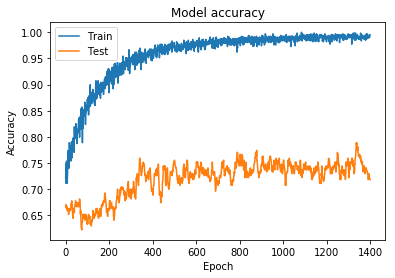

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Train and test on GT_split 3

In [15]:
Train = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 265/265 [00:01<00:00, 190.45it/s]


In [16]:
# Re-initialize weights, since training and testing data switch
LDT_Net = build_LDT_Net(C)

In [17]:
from keras.callbacks import ModelCheckpoint
import keras
lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
'''
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
'''
# checkpoint 报存最好的模型
filepath="weights.GT3best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


history = LDT_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1400,
                    verbose=True,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 663 samples, validate on 265 samples
Epoch 1/800
663/663 [==============================] - 4s 7ms/step - loss: 4.0380 - acc: 0.0528 - val_loss: 3.3613 - val_acc: 0.0679
Epoch 2/800
663/663 [==============================] - 0s 92us/step - loss: 3.9557 - acc: 0.0498 - val_loss: 3.2585 - val_acc: 0.0642
Epoch 3/800
663/663 [==============================] - 0s 84us/step - loss: 3.7126 - acc: 0.0618 - val_loss: 3.1628 - val_acc: 0.0679
Epoch 4/800
663/663 [==============================] - 0s 88us/step - loss: 3.6505 - acc: 0.0664 - val_loss: 3.0775 - val_acc: 0.0717
Epoch 5/800
663/663 [==============================] - 0s 84us/step - loss: 3.4601 - acc: 0.0845 - val_loss: 3.0039 - val_acc: 0.0755
Epoch 6/800
663/663 [==============================] - 0s 89us/step - loss: 3.3683 - acc: 0.0860 - val_loss: 2.9409 - val_acc: 0.0868
Epoch 7/800
663/663 [==============================] - 0s 84us/step - loss: 3.2339 - acc: 0.1192 - val_loss: 2.8832 - val_acc: 0.1132
Epoch 8/800
663/6

Epoch 62/800
663/663 [==============================] - 0s 87us/step - loss: 1.3007 - acc: 0.5928 - val_loss: 1.6902 - val_acc: 0.4604
Epoch 63/800
663/663 [==============================] - 0s 86us/step - loss: 1.2946 - acc: 0.6199 - val_loss: 1.6997 - val_acc: 0.4566
Epoch 64/800
663/663 [==============================] - 0s 89us/step - loss: 1.2463 - acc: 0.6305 - val_loss: 1.7094 - val_acc: 0.4566
Epoch 65/800
663/663 [==============================] - 0s 88us/step - loss: 1.2382 - acc: 0.5973 - val_loss: 1.7222 - val_acc: 0.4604
Epoch 66/800
663/663 [==============================] - 0s 85us/step - loss: 1.2292 - acc: 0.6290 - val_loss: 1.7231 - val_acc: 0.4528
Epoch 67/800
663/663 [==============================] - 0s 86us/step - loss: 1.2652 - acc: 0.6124 - val_loss: 1.7266 - val_acc: 0.4604
Epoch 68/800
663/663 [==============================] - 0s 91us/step - loss: 1.2562 - acc: 0.6169 - val_loss: 1.7254 - val_acc: 0.4642
Epoch 69/800
663/663 [==============================] -

Epoch 123/800
663/663 [==============================] - 0s 81us/step - loss: 0.9177 - acc: 0.7164 - val_loss: 1.2476 - val_acc: 0.5887
Epoch 124/800
663/663 [==============================] - 0s 83us/step - loss: 0.8946 - acc: 0.7104 - val_loss: 1.2423 - val_acc: 0.5962
Epoch 125/800
663/663 [==============================] - 0s 89us/step - loss: 0.8842 - acc: 0.7345 - val_loss: 1.2376 - val_acc: 0.5962
Epoch 126/800
663/663 [==============================] - 0s 82us/step - loss: 0.8998 - acc: 0.7195 - val_loss: 1.2332 - val_acc: 0.6000
Epoch 127/800
663/663 [==============================] - 0s 92us/step - loss: 0.8914 - acc: 0.7285 - val_loss: 1.2291 - val_acc: 0.6000
Epoch 128/800
663/663 [==============================] - 0s 87us/step - loss: 0.8741 - acc: 0.7149 - val_loss: 1.2252 - val_acc: 0.6000
Epoch 129/800
663/663 [==============================] - 0s 82us/step - loss: 0.9433 - acc: 0.6833 - val_loss: 1.2214 - val_acc: 0.6000
Epoch 130/800
663/663 [=========================

Epoch 184/800
663/663 [==============================] - 0s 86us/step - loss: 0.8877 - acc: 0.7315 - val_loss: 1.1292 - val_acc: 0.6377
Epoch 185/800
663/663 [==============================] - 0s 88us/step - loss: 0.8788 - acc: 0.7315 - val_loss: 1.1285 - val_acc: 0.6377
Epoch 186/800
663/663 [==============================] - 0s 80us/step - loss: 0.8738 - acc: 0.7345 - val_loss: 1.1278 - val_acc: 0.6377
Epoch 187/800
663/663 [==============================] - 0s 90us/step - loss: 0.8738 - acc: 0.7391 - val_loss: 1.1272 - val_acc: 0.6377
Epoch 188/800
663/663 [==============================] - 0s 87us/step - loss: 0.8913 - acc: 0.7315 - val_loss: 1.1265 - val_acc: 0.6377
Epoch 189/800
663/663 [==============================] - 0s 95us/step - loss: 0.9249 - acc: 0.7179 - val_loss: 1.1259 - val_acc: 0.6377
Epoch 190/800
663/663 [==============================] - 0s 86us/step - loss: 0.8892 - acc: 0.7104 - val_loss: 1.1253 - val_acc: 0.6377
Epoch 191/800
663/663 [=========================

Epoch 245/800
663/663 [==============================] - 0s 84us/step - loss: 0.8563 - acc: 0.7300 - val_loss: 1.1083 - val_acc: 0.6377
Epoch 246/800
663/663 [==============================] - 0s 91us/step - loss: 0.8419 - acc: 0.7315 - val_loss: 1.1082 - val_acc: 0.6377
Epoch 247/800
663/663 [==============================] - 0s 90us/step - loss: 0.8804 - acc: 0.7134 - val_loss: 1.1080 - val_acc: 0.6377
Epoch 248/800
663/663 [==============================] - 0s 87us/step - loss: 0.8498 - acc: 0.7376 - val_loss: 1.1079 - val_acc: 0.6377
Epoch 249/800
663/663 [==============================] - 0s 87us/step - loss: 0.8658 - acc: 0.7345 - val_loss: 1.1077 - val_acc: 0.6377
Epoch 250/800
663/663 [==============================] - 0s 98us/step - loss: 0.8990 - acc: 0.7195 - val_loss: 1.1076 - val_acc: 0.6415
Epoch 251/800
663/663 [==============================] - 0s 87us/step - loss: 0.8844 - acc: 0.7179 - val_loss: 1.1075 - val_acc: 0.6415
Epoch 252/800
663/663 [=========================

Epoch 306/800
663/663 [==============================] - 0s 92us/step - loss: 0.8608 - acc: 0.7330 - val_loss: 1.1035 - val_acc: 0.6604
Epoch 307/800
663/663 [==============================] - 0s 87us/step - loss: 0.8648 - acc: 0.7255 - val_loss: 1.1034 - val_acc: 0.6604
Epoch 308/800
663/663 [==============================] - 0s 92us/step - loss: 0.8795 - acc: 0.7345 - val_loss: 1.1034 - val_acc: 0.6604
Epoch 309/800
663/663 [==============================] - 0s 87us/step - loss: 0.8758 - acc: 0.7421 - val_loss: 1.1034 - val_acc: 0.6604
Epoch 310/800
663/663 [==============================] - 0s 92us/step - loss: 0.8825 - acc: 0.7360 - val_loss: 1.1034 - val_acc: 0.6604
Epoch 311/800
663/663 [==============================] - 0s 90us/step - loss: 0.8807 - acc: 0.7149 - val_loss: 1.1033 - val_acc: 0.6604
Epoch 312/800
663/663 [==============================] - 0s 95us/step - loss: 0.8890 - acc: 0.7149 - val_loss: 1.1032 - val_acc: 0.6604
Epoch 313/800
663/663 [=========================

Epoch 367/800
663/663 [==============================] - 0s 97us/step - loss: 0.8575 - acc: 0.7376 - val_loss: 1.1009 - val_acc: 0.6566
Epoch 368/800
663/663 [==============================] - 0s 89us/step - loss: 0.8495 - acc: 0.7376 - val_loss: 1.1009 - val_acc: 0.6566
Epoch 369/800
663/663 [==============================] - 0s 85us/step - loss: 0.8205 - acc: 0.7330 - val_loss: 1.1008 - val_acc: 0.6566
Epoch 370/800
663/663 [==============================] - 0s 87us/step - loss: 0.8539 - acc: 0.7406 - val_loss: 1.1008 - val_acc: 0.6566
Epoch 371/800
663/663 [==============================] - 0s 83us/step - loss: 0.8875 - acc: 0.7315 - val_loss: 1.1008 - val_acc: 0.6566
Epoch 372/800
663/663 [==============================] - 0s 84us/step - loss: 0.8565 - acc: 0.7481 - val_loss: 1.1007 - val_acc: 0.6566
Epoch 373/800
663/663 [==============================] - 0s 92us/step - loss: 0.9083 - acc: 0.7134 - val_loss: 1.1007 - val_acc: 0.6566
Epoch 374/800
663/663 [=========================

Epoch 428/800
663/663 [==============================] - 0s 87us/step - loss: 0.8294 - acc: 0.7541 - val_loss: 1.0992 - val_acc: 0.6528
Epoch 429/800
663/663 [==============================] - 0s 90us/step - loss: 0.8405 - acc: 0.7345 - val_loss: 1.0991 - val_acc: 0.6528
Epoch 430/800
663/663 [==============================] - 0s 91us/step - loss: 0.8468 - acc: 0.7421 - val_loss: 1.0991 - val_acc: 0.6528
Epoch 431/800
663/663 [==============================] - 0s 85us/step - loss: 0.8277 - acc: 0.7345 - val_loss: 1.0991 - val_acc: 0.6528
Epoch 432/800
663/663 [==============================] - 0s 85us/step - loss: 0.9012 - acc: 0.7104 - val_loss: 1.0991 - val_acc: 0.6528
Epoch 433/800
663/663 [==============================] - 0s 90us/step - loss: 0.9028 - acc: 0.7270 - val_loss: 1.0990 - val_acc: 0.6528
Epoch 434/800
663/663 [==============================] - 0s 88us/step - loss: 0.8602 - acc: 0.7315 - val_loss: 1.0990 - val_acc: 0.6528
Epoch 435/800
663/663 [=========================

Epoch 489/800
663/663 [==============================] - 0s 95us/step - loss: 0.8640 - acc: 0.7406 - val_loss: 1.0974 - val_acc: 0.6566
Epoch 490/800
663/663 [==============================] - 0s 83us/step - loss: 0.8299 - acc: 0.7496 - val_loss: 1.0974 - val_acc: 0.6566
Epoch 491/800
663/663 [==============================] - 0s 90us/step - loss: 0.8269 - acc: 0.7391 - val_loss: 1.0973 - val_acc: 0.6566
Epoch 492/800
663/663 [==============================] - 0s 86us/step - loss: 0.8726 - acc: 0.7285 - val_loss: 1.0973 - val_acc: 0.6566
Epoch 493/800
663/663 [==============================] - 0s 84us/step - loss: 0.8559 - acc: 0.7511 - val_loss: 1.0973 - val_acc: 0.6566
Epoch 494/800
663/663 [==============================] - 0s 93us/step - loss: 0.8486 - acc: 0.7376 - val_loss: 1.0973 - val_acc: 0.6566
Epoch 495/800
663/663 [==============================] - 0s 86us/step - loss: 0.8156 - acc: 0.7526 - val_loss: 1.0973 - val_acc: 0.6566
Epoch 496/800
663/663 [=========================

Epoch 550/800
663/663 [==============================] - 0s 84us/step - loss: 0.8413 - acc: 0.7481 - val_loss: 1.0955 - val_acc: 0.6566
Epoch 551/800
663/663 [==============================] - 0s 90us/step - loss: 0.8616 - acc: 0.7391 - val_loss: 1.0954 - val_acc: 0.6566
Epoch 552/800
663/663 [==============================] - 0s 87us/step - loss: 0.8297 - acc: 0.7406 - val_loss: 1.0954 - val_acc: 0.6566
Epoch 553/800
663/663 [==============================] - 0s 88us/step - loss: 0.8716 - acc: 0.7436 - val_loss: 1.0953 - val_acc: 0.6566
Epoch 554/800
663/663 [==============================] - 0s 87us/step - loss: 0.8517 - acc: 0.7330 - val_loss: 1.0953 - val_acc: 0.6566
Epoch 555/800
663/663 [==============================] - 0s 87us/step - loss: 0.8578 - acc: 0.7436 - val_loss: 1.0953 - val_acc: 0.6566
Epoch 556/800
663/663 [==============================] - 0s 87us/step - loss: 0.8700 - acc: 0.7315 - val_loss: 1.0952 - val_acc: 0.6566
Epoch 557/800
663/663 [=========================

Epoch 611/800
663/663 [==============================] - 0s 84us/step - loss: 0.8245 - acc: 0.7406 - val_loss: 1.0933 - val_acc: 0.6566
Epoch 612/800
663/663 [==============================] - 0s 89us/step - loss: 0.8175 - acc: 0.7466 - val_loss: 1.0933 - val_acc: 0.6566
Epoch 613/800
663/663 [==============================] - 0s 88us/step - loss: 0.9063 - acc: 0.7240 - val_loss: 1.0933 - val_acc: 0.6566
Epoch 614/800
663/663 [==============================] - 0s 86us/step - loss: 0.8548 - acc: 0.7587 - val_loss: 1.0933 - val_acc: 0.6566
Epoch 615/800
663/663 [==============================] - 0s 88us/step - loss: 0.8646 - acc: 0.7421 - val_loss: 1.0933 - val_acc: 0.6566
Epoch 616/800
663/663 [==============================] - 0s 96us/step - loss: 0.8486 - acc: 0.7330 - val_loss: 1.0932 - val_acc: 0.6566
Epoch 617/800
663/663 [==============================] - 0s 91us/step - loss: 0.8616 - acc: 0.7391 - val_loss: 1.0931 - val_acc: 0.6566
Epoch 618/800
663/663 [=========================

Epoch 672/800
663/663 [==============================] - 0s 87us/step - loss: 0.8562 - acc: 0.7376 - val_loss: 1.0920 - val_acc: 0.6566
Epoch 673/800
663/663 [==============================] - 0s 84us/step - loss: 0.8396 - acc: 0.7451 - val_loss: 1.0920 - val_acc: 0.6566
Epoch 674/800
663/663 [==============================] - 0s 96us/step - loss: 0.8302 - acc: 0.7406 - val_loss: 1.0920 - val_acc: 0.6566
Epoch 675/800
663/663 [==============================] - 0s 84us/step - loss: 0.8358 - acc: 0.7436 - val_loss: 1.0920 - val_acc: 0.6566
Epoch 676/800
663/663 [==============================] - 0s 88us/step - loss: 0.8816 - acc: 0.7240 - val_loss: 1.0919 - val_acc: 0.6566
Epoch 677/800
663/663 [==============================] - 0s 89us/step - loss: 0.8523 - acc: 0.7330 - val_loss: 1.0919 - val_acc: 0.6566
Epoch 678/800
663/663 [==============================] - 0s 81us/step - loss: 0.8726 - acc: 0.7164 - val_loss: 1.0919 - val_acc: 0.6566
Epoch 679/800
663/663 [=========================

Epoch 733/800
663/663 [==============================] - 0s 89us/step - loss: 0.8838 - acc: 0.7285 - val_loss: 1.0905 - val_acc: 0.6604
Epoch 734/800
663/663 [==============================] - 0s 85us/step - loss: 0.8079 - acc: 0.7572 - val_loss: 1.0905 - val_acc: 0.6604
Epoch 735/800
663/663 [==============================] - 0s 85us/step - loss: 0.8773 - acc: 0.7270 - val_loss: 1.0905 - val_acc: 0.6604
Epoch 736/800
663/663 [==============================] - 0s 95us/step - loss: 0.7941 - acc: 0.7617 - val_loss: 1.0905 - val_acc: 0.6604
Epoch 737/800
663/663 [==============================] - 0s 96us/step - loss: 0.7984 - acc: 0.7541 - val_loss: 1.0904 - val_acc: 0.6604
Epoch 738/800
663/663 [==============================] - 0s 88us/step - loss: 0.8941 - acc: 0.7330 - val_loss: 1.0904 - val_acc: 0.6604
Epoch 739/800
663/663 [==============================] - 0s 96us/step - loss: 0.8034 - acc: 0.7541 - val_loss: 1.0904 - val_acc: 0.6604
Epoch 740/800
663/663 [=========================

Epoch 794/800
663/663 [==============================] - 0s 92us/step - loss: 0.8250 - acc: 0.7195 - val_loss: 1.0889 - val_acc: 0.6642
Epoch 795/800
663/663 [==============================] - 0s 91us/step - loss: 0.8721 - acc: 0.7330 - val_loss: 1.0888 - val_acc: 0.6642
Epoch 796/800
663/663 [==============================] - 0s 91us/step - loss: 0.8311 - acc: 0.7647 - val_loss: 1.0888 - val_acc: 0.6642
Epoch 797/800
663/663 [==============================] - 0s 83us/step - loss: 0.8289 - acc: 0.7421 - val_loss: 1.0887 - val_acc: 0.6642
Epoch 798/800
663/663 [==============================] - 0s 89us/step - loss: 0.8616 - acc: 0.7195 - val_loss: 1.0887 - val_acc: 0.6642
Epoch 799/800
663/663 [==============================] - 0s 86us/step - loss: 0.8280 - acc: 0.7345 - val_loss: 1.0887 - val_acc: 0.6642
Epoch 800/800
663/663 [==============================] - 0s 91us/step - loss: 0.8581 - acc: 0.7270 - val_loss: 1.0887 - val_acc: 0.6642
Train on 663 samples, validate on 265 samples
Ep

663/663 [==============================] - 0s 92us/step - loss: 0.5923 - acc: 0.8205 - val_loss: 1.0751 - val_acc: 0.6340

Epoch 00041: val_acc did not improve
Epoch 42/1400
663/663 [==============================] - 0s 81us/step - loss: 0.6101 - acc: 0.8069 - val_loss: 1.0763 - val_acc: 0.6415

Epoch 00042: val_acc did not improve
Epoch 43/1400
663/663 [==============================] - 0s 84us/step - loss: 0.6102 - acc: 0.8130 - val_loss: 1.0798 - val_acc: 0.6377

Epoch 00043: val_acc did not improve
Epoch 44/1400
663/663 [==============================] - 0s 93us/step - loss: 0.5796 - acc: 0.8250 - val_loss: 1.0866 - val_acc: 0.6415

Epoch 00044: val_acc did not improve
Epoch 45/1400
663/663 [==============================] - 0s 84us/step - loss: 0.5853 - acc: 0.8084 - val_loss: 1.0939 - val_acc: 0.6340

Epoch 00045: val_acc did not improve
Epoch 46/1400
663/663 [==============================] - 0s 88us/step - loss: 0.6374 - acc: 0.8009 - val_loss: 1.0991 - val_acc: 0.6377

Epoch 0


Epoch 00088: val_acc did not improve
Epoch 89/1400
663/663 [==============================] - 0s 84us/step - loss: 0.4707 - acc: 0.8477 - val_loss: 1.1580 - val_acc: 0.6566

Epoch 00089: val_acc did not improve
Epoch 90/1400
663/663 [==============================] - 0s 90us/step - loss: 0.4577 - acc: 0.8492 - val_loss: 1.1604 - val_acc: 0.6642

Epoch 00090: val_acc did not improve
Epoch 91/1400
663/663 [==============================] - 0s 87us/step - loss: 0.4323 - acc: 0.8507 - val_loss: 1.1671 - val_acc: 0.6642

Epoch 00091: val_acc did not improve
Epoch 92/1400
663/663 [==============================] - 0s 86us/step - loss: 0.4694 - acc: 0.8507 - val_loss: 1.1701 - val_acc: 0.6604

Epoch 00092: val_acc did not improve
Epoch 93/1400
663/663 [==============================] - 0s 84us/step - loss: 0.4762 - acc: 0.8446 - val_loss: 1.1721 - val_acc: 0.6566

Epoch 00093: val_acc did not improve
Epoch 94/1400
663/663 [==============================] - 0s 94us/step - loss: 0.4228 - acc: 


Epoch 00135: val_acc did not improve
Epoch 136/1400
663/663 [==============================] - 0s 84us/step - loss: 0.3881 - acc: 0.8824 - val_loss: 1.0477 - val_acc: 0.6830

Epoch 00136: val_acc did not improve
Epoch 137/1400
663/663 [==============================] - 0s 86us/step - loss: 0.3712 - acc: 0.8914 - val_loss: 1.0397 - val_acc: 0.6868

Epoch 00137: val_acc did not improve
Epoch 138/1400
663/663 [==============================] - 0s 86us/step - loss: 0.3108 - acc: 0.9005 - val_loss: 1.0342 - val_acc: 0.6830

Epoch 00138: val_acc did not improve
Epoch 139/1400
663/663 [==============================] - 0s 88us/step - loss: 0.3410 - acc: 0.8884 - val_loss: 1.0307 - val_acc: 0.6906

Epoch 00139: val_acc improved from 0.68679 to 0.69057, saving model to weights.GT3best.hdf5
Epoch 140/1400
663/663 [==============================] - 0s 85us/step - loss: 0.3329 - acc: 0.8974 - val_loss: 1.0308 - val_acc: 0.6981

Epoch 00140: val_acc improved from 0.69057 to 0.69811, saving model t

663/663 [==============================] - 0s 86us/step - loss: 0.2789 - acc: 0.9080 - val_loss: 1.1765 - val_acc: 0.6755

Epoch 00182: val_acc did not improve
Epoch 183/1400
663/663 [==============================] - 0s 89us/step - loss: 0.2691 - acc: 0.9035 - val_loss: 1.1698 - val_acc: 0.6792

Epoch 00183: val_acc did not improve
Epoch 184/1400
663/663 [==============================] - 0s 87us/step - loss: 0.2719 - acc: 0.9216 - val_loss: 1.1553 - val_acc: 0.6830

Epoch 00184: val_acc did not improve
Epoch 185/1400
663/663 [==============================] - 0s 83us/step - loss: 0.2446 - acc: 0.9201 - val_loss: 1.1404 - val_acc: 0.6906

Epoch 00185: val_acc did not improve
Epoch 186/1400
663/663 [==============================] - 0s 87us/step - loss: 0.3014 - acc: 0.9065 - val_loss: 1.1222 - val_acc: 0.6868

Epoch 00186: val_acc did not improve
Epoch 187/1400
663/663 [==============================] - 0s 86us/step - loss: 0.2654 - acc: 0.9336 - val_loss: 1.1014 - val_acc: 0.6830

Ep


Epoch 00228: val_acc did not improve
Epoch 229/1400
663/663 [==============================] - 0s 89us/step - loss: 0.2381 - acc: 0.9231 - val_loss: 1.0682 - val_acc: 0.7019

Epoch 00229: val_acc did not improve
Epoch 230/1400
663/663 [==============================] - 0s 91us/step - loss: 0.2266 - acc: 0.9367 - val_loss: 1.0611 - val_acc: 0.6981

Epoch 00230: val_acc did not improve
Epoch 231/1400
663/663 [==============================] - 0s 83us/step - loss: 0.2008 - acc: 0.9548 - val_loss: 1.0555 - val_acc: 0.6981

Epoch 00231: val_acc did not improve
Epoch 232/1400
663/663 [==============================] - 0s 93us/step - loss: 0.2150 - acc: 0.9412 - val_loss: 1.0515 - val_acc: 0.6981

Epoch 00232: val_acc did not improve
Epoch 233/1400
663/663 [==============================] - 0s 85us/step - loss: 0.2282 - acc: 0.9276 - val_loss: 1.0481 - val_acc: 0.7057

Epoch 00233: val_acc did not improve
Epoch 234/1400
663/663 [==============================] - 0s 85us/step - loss: 0.2342 -


Epoch 00275: val_acc did not improve
Epoch 276/1400
663/663 [==============================] - 0s 79us/step - loss: 0.1843 - acc: 0.9457 - val_loss: 1.0411 - val_acc: 0.7094

Epoch 00276: val_acc did not improve
Epoch 277/1400
663/663 [==============================] - 0s 80us/step - loss: 0.1867 - acc: 0.9382 - val_loss: 1.0349 - val_acc: 0.7132

Epoch 00277: val_acc did not improve
Epoch 278/1400
663/663 [==============================] - 0s 85us/step - loss: 0.1702 - acc: 0.9517 - val_loss: 1.0269 - val_acc: 0.7170

Epoch 00278: val_acc did not improve
Epoch 279/1400
663/663 [==============================] - 0s 86us/step - loss: 0.1781 - acc: 0.9457 - val_loss: 1.0196 - val_acc: 0.7283

Epoch 00279: val_acc improved from 0.72453 to 0.72830, saving model to weights.GT3best.hdf5
Epoch 280/1400
663/663 [==============================] - 0s 90us/step - loss: 0.1820 - acc: 0.9457 - val_loss: 1.0189 - val_acc: 0.7434

Epoch 00280: val_acc improved from 0.72830 to 0.74340, saving model t

663/663 [==============================] - 0s 83us/step - loss: 0.1647 - acc: 0.9517 - val_loss: 1.0772 - val_acc: 0.7019

Epoch 00322: val_acc did not improve
Epoch 323/1400
663/663 [==============================] - 0s 91us/step - loss: 0.1529 - acc: 0.9638 - val_loss: 1.0844 - val_acc: 0.6906

Epoch 00323: val_acc did not improve
Epoch 324/1400
663/663 [==============================] - 0s 87us/step - loss: 0.1657 - acc: 0.9578 - val_loss: 1.0942 - val_acc: 0.6906

Epoch 00324: val_acc did not improve
Epoch 325/1400
663/663 [==============================] - 0s 90us/step - loss: 0.1484 - acc: 0.9638 - val_loss: 1.1082 - val_acc: 0.6830

Epoch 00325: val_acc did not improve
Epoch 326/1400
663/663 [==============================] - 0s 88us/step - loss: 0.1752 - acc: 0.9427 - val_loss: 1.1224 - val_acc: 0.6868

Epoch 00326: val_acc did not improve
Epoch 327/1400
663/663 [==============================] - 0s 78us/step - loss: 0.1870 - acc: 0.9472 - val_loss: 1.1445 - val_acc: 0.6943

Ep

663/663 [==============================] - 0s 88us/step - loss: 0.1427 - acc: 0.9578 - val_loss: 1.0730 - val_acc: 0.7170

Epoch 00369: val_acc did not improve
Epoch 370/1400
663/663 [==============================] - 0s 82us/step - loss: 0.1445 - acc: 0.9578 - val_loss: 1.0714 - val_acc: 0.7132

Epoch 00370: val_acc did not improve
Epoch 371/1400
663/663 [==============================] - 0s 82us/step - loss: 0.1389 - acc: 0.9638 - val_loss: 1.0708 - val_acc: 0.7057

Epoch 00371: val_acc did not improve
Epoch 372/1400
663/663 [==============================] - 0s 90us/step - loss: 0.1413 - acc: 0.9668 - val_loss: 1.0718 - val_acc: 0.7019

Epoch 00372: val_acc did not improve
Epoch 373/1400
663/663 [==============================] - 0s 80us/step - loss: 0.1414 - acc: 0.9563 - val_loss: 1.0722 - val_acc: 0.7057

Epoch 00373: val_acc did not improve
Epoch 374/1400
663/663 [==============================] - 0s 89us/step - loss: 0.1329 - acc: 0.9608 - val_loss: 1.0738 - val_acc: 0.7057

Ep

663/663 [==============================] - 0s 84us/step - loss: 0.1138 - acc: 0.9638 - val_loss: 1.0475 - val_acc: 0.7245

Epoch 00416: val_acc did not improve
Epoch 417/1400
663/663 [==============================] - 0s 84us/step - loss: 0.1061 - acc: 0.9668 - val_loss: 1.0492 - val_acc: 0.7283

Epoch 00417: val_acc did not improve
Epoch 418/1400
663/663 [==============================] - 0s 84us/step - loss: 0.1207 - acc: 0.9623 - val_loss: 1.0555 - val_acc: 0.7208

Epoch 00418: val_acc did not improve
Epoch 419/1400
663/663 [==============================] - 0s 90us/step - loss: 0.1312 - acc: 0.9578 - val_loss: 1.0607 - val_acc: 0.7170

Epoch 00419: val_acc did not improve
Epoch 420/1400
663/663 [==============================] - 0s 87us/step - loss: 0.1343 - acc: 0.9532 - val_loss: 1.0671 - val_acc: 0.7321

Epoch 00420: val_acc did not improve
Epoch 421/1400
663/663 [==============================] - 0s 80us/step - loss: 0.1331 - acc: 0.9532 - val_loss: 1.0763 - val_acc: 0.7358

Ep

663/663 [==============================] - 0s 89us/step - loss: 0.1182 - acc: 0.9668 - val_loss: 1.1153 - val_acc: 0.7321

Epoch 00463: val_acc did not improve
Epoch 464/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0951 - acc: 0.9804 - val_loss: 1.1055 - val_acc: 0.7434

Epoch 00464: val_acc did not improve
Epoch 465/1400
663/663 [==============================] - 0s 92us/step - loss: 0.0749 - acc: 0.9804 - val_loss: 1.0960 - val_acc: 0.7434

Epoch 00465: val_acc did not improve
Epoch 466/1400
663/663 [==============================] - 0s 79us/step - loss: 0.1227 - acc: 0.9638 - val_loss: 1.0903 - val_acc: 0.7472

Epoch 00466: val_acc improved from 0.74340 to 0.74717, saving model to weights.GT3best.hdf5
Epoch 467/1400
663/663 [==============================] - 0s 84us/step - loss: 0.1048 - acc: 0.9683 - val_loss: 1.0996 - val_acc: 0.7358

Epoch 00467: val_acc did not improve
Epoch 468/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0782


Epoch 00509: val_acc did not improve
Epoch 510/1400
663/663 [==============================] - 0s 75us/step - loss: 0.0794 - acc: 0.9849 - val_loss: 1.1366 - val_acc: 0.7396

Epoch 00510: val_acc did not improve
Epoch 511/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0871 - acc: 0.9744 - val_loss: 1.1374 - val_acc: 0.7358

Epoch 00511: val_acc did not improve
Epoch 512/1400
663/663 [==============================] - 0s 82us/step - loss: 0.1049 - acc: 0.9713 - val_loss: 1.1347 - val_acc: 0.7509

Epoch 00512: val_acc did not improve
Epoch 513/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0975 - acc: 0.9713 - val_loss: 1.1316 - val_acc: 0.7509

Epoch 00513: val_acc did not improve
Epoch 514/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0761 - acc: 0.9819 - val_loss: 1.1256 - val_acc: 0.7509

Epoch 00514: val_acc did not improve
Epoch 515/1400
663/663 [==============================] - 0s 85us/step - loss: 0.1227 -


Epoch 00555: val_acc did not improve
Epoch 556/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0901 - acc: 0.9729 - val_loss: 1.0905 - val_acc: 0.7358

Epoch 00556: val_acc did not improve
Epoch 557/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0759 - acc: 0.9759 - val_loss: 1.0970 - val_acc: 0.7283

Epoch 00557: val_acc did not improve
Epoch 558/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0855 - acc: 0.9774 - val_loss: 1.0961 - val_acc: 0.7283

Epoch 00558: val_acc did not improve
Epoch 559/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0928 - acc: 0.9713 - val_loss: 1.0973 - val_acc: 0.7208

Epoch 00559: val_acc did not improve
Epoch 560/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0733 - acc: 0.9789 - val_loss: 1.0976 - val_acc: 0.7208

Epoch 00560: val_acc did not improve
Epoch 561/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0887 -


Epoch 00602: val_acc did not improve
Epoch 603/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0982 - acc: 0.9713 - val_loss: 1.1377 - val_acc: 0.7208

Epoch 00603: val_acc did not improve
Epoch 604/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0779 - acc: 0.9834 - val_loss: 1.1324 - val_acc: 0.7208

Epoch 00604: val_acc did not improve
Epoch 605/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0844 - acc: 0.9759 - val_loss: 1.1338 - val_acc: 0.7245

Epoch 00605: val_acc did not improve
Epoch 606/1400
663/663 [==============================] - 0s 91us/step - loss: 0.0851 - acc: 0.9713 - val_loss: 1.1374 - val_acc: 0.7245

Epoch 00606: val_acc did not improve
Epoch 607/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0741 - acc: 0.9789 - val_loss: 1.1409 - val_acc: 0.7132

Epoch 00607: val_acc did not improve
Epoch 608/1400
663/663 [==============================] - 0s 79us/step - loss: 0.0586 -


Epoch 00649: val_acc did not improve
Epoch 650/1400
663/663 [==============================] - 0s 80us/step - loss: 0.0735 - acc: 0.9804 - val_loss: 1.0941 - val_acc: 0.7283

Epoch 00650: val_acc did not improve
Epoch 651/1400
663/663 [==============================] - 0s 98us/step - loss: 0.0690 - acc: 0.9774 - val_loss: 1.0879 - val_acc: 0.7358

Epoch 00651: val_acc did not improve
Epoch 652/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0544 - acc: 0.9894 - val_loss: 1.0860 - val_acc: 0.7358

Epoch 00652: val_acc did not improve
Epoch 653/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0576 - acc: 0.9819 - val_loss: 1.0902 - val_acc: 0.7321

Epoch 00653: val_acc did not improve
Epoch 654/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0787 - acc: 0.9789 - val_loss: 1.0975 - val_acc: 0.7245

Epoch 00654: val_acc did not improve
Epoch 655/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0732 -


Epoch 00696: val_acc did not improve
Epoch 697/1400
663/663 [==============================] - 0s 79us/step - loss: 0.0646 - acc: 0.9804 - val_loss: 1.1461 - val_acc: 0.7358

Epoch 00697: val_acc did not improve
Epoch 698/1400
663/663 [==============================] - 0s 81us/step - loss: 0.0449 - acc: 0.9864 - val_loss: 1.1514 - val_acc: 0.7396

Epoch 00698: val_acc did not improve
Epoch 699/1400
663/663 [==============================] - 0s 94us/step - loss: 0.0967 - acc: 0.9698 - val_loss: 1.1548 - val_acc: 0.7434

Epoch 00699: val_acc did not improve
Epoch 700/1400
663/663 [==============================] - 0s 94us/step - loss: 0.0472 - acc: 0.9910 - val_loss: 1.1595 - val_acc: 0.7472

Epoch 00700: val_acc did not improve
Epoch 701/1400
663/663 [==============================] - 0s 97us/step - loss: 0.0678 - acc: 0.9849 - val_loss: 1.1671 - val_acc: 0.7472

Epoch 00701: val_acc did not improve
Epoch 702/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0708 -


Epoch 00743: val_acc did not improve
Epoch 744/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0558 - acc: 0.9849 - val_loss: 1.1963 - val_acc: 0.7358

Epoch 00744: val_acc did not improve
Epoch 745/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0700 - acc: 0.9819 - val_loss: 1.1836 - val_acc: 0.7472

Epoch 00745: val_acc did not improve
Epoch 746/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0628 - acc: 0.9804 - val_loss: 1.1745 - val_acc: 0.7547

Epoch 00746: val_acc did not improve
Epoch 747/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0557 - acc: 0.9879 - val_loss: 1.1679 - val_acc: 0.7547

Epoch 00747: val_acc did not improve
Epoch 748/1400
663/663 [==============================] - 0s 91us/step - loss: 0.0682 - acc: 0.9789 - val_loss: 1.1642 - val_acc: 0.7472

Epoch 00748: val_acc did not improve
Epoch 749/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0617 -


Epoch 00790: val_acc did not improve
Epoch 791/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0569 - acc: 0.9774 - val_loss: 1.1893 - val_acc: 0.7472

Epoch 00791: val_acc did not improve
Epoch 792/1400
663/663 [==============================] - 0s 91us/step - loss: 0.0420 - acc: 0.9879 - val_loss: 1.1829 - val_acc: 0.7509

Epoch 00792: val_acc did not improve
Epoch 793/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0468 - acc: 0.9879 - val_loss: 1.1742 - val_acc: 0.7434

Epoch 00793: val_acc did not improve
Epoch 794/1400
663/663 [==============================] - 0s 92us/step - loss: 0.0585 - acc: 0.9849 - val_loss: 1.1688 - val_acc: 0.7434

Epoch 00794: val_acc did not improve
Epoch 795/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0718 - acc: 0.9789 - val_loss: 1.1606 - val_acc: 0.7509

Epoch 00795: val_acc did not improve
Epoch 796/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0724 -


Epoch 00837: val_acc did not improve
Epoch 838/1400
663/663 [==============================] - 0s 78us/step - loss: 0.0618 - acc: 0.9849 - val_loss: 1.0981 - val_acc: 0.7698

Epoch 00838: val_acc improved from 0.76604 to 0.76981, saving model to weights.GT3best.hdf5
Epoch 839/1400
663/663 [==============================] - 0s 96us/step - loss: 0.0567 - acc: 0.9849 - val_loss: 1.1010 - val_acc: 0.7698

Epoch 00839: val_acc did not improve
Epoch 840/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0461 - acc: 0.9879 - val_loss: 1.1056 - val_acc: 0.7623

Epoch 00840: val_acc did not improve
Epoch 841/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0451 - acc: 0.9849 - val_loss: 1.1097 - val_acc: 0.7623

Epoch 00841: val_acc did not improve
Epoch 842/1400
663/663 [==============================] - 0s 79us/step - loss: 0.0425 - acc: 0.9925 - val_loss: 1.1159 - val_acc: 0.7660

Epoch 00842: val_acc did not improve
Epoch 843/1400
663/663 [========


Epoch 00884: val_acc did not improve
Epoch 885/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0547 - acc: 0.9849 - val_loss: 1.1784 - val_acc: 0.7358

Epoch 00885: val_acc did not improve
Epoch 886/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0765 - acc: 0.9729 - val_loss: 1.1840 - val_acc: 0.7358

Epoch 00886: val_acc did not improve
Epoch 887/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0532 - acc: 0.9804 - val_loss: 1.1873 - val_acc: 0.7321

Epoch 00887: val_acc did not improve
Epoch 888/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0543 - acc: 0.9894 - val_loss: 1.1879 - val_acc: 0.7321

Epoch 00888: val_acc did not improve
Epoch 889/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0509 - acc: 0.9894 - val_loss: 1.1916 - val_acc: 0.7208

Epoch 00889: val_acc did not improve
Epoch 890/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0479 -


Epoch 00931: val_acc did not improve
Epoch 932/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0501 - acc: 0.9894 - val_loss: 1.2069 - val_acc: 0.7623

Epoch 00932: val_acc did not improve
Epoch 933/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0527 - acc: 0.9819 - val_loss: 1.2008 - val_acc: 0.7623

Epoch 00933: val_acc did not improve
Epoch 934/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0478 - acc: 0.9849 - val_loss: 1.1930 - val_acc: 0.7547

Epoch 00934: val_acc did not improve
Epoch 935/1400
663/663 [==============================] - 0s 91us/step - loss: 0.0598 - acc: 0.9834 - val_loss: 1.1866 - val_acc: 0.7623

Epoch 00935: val_acc did not improve
Epoch 936/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0523 - acc: 0.9804 - val_loss: 1.1811 - val_acc: 0.7623

Epoch 00936: val_acc did not improve
Epoch 937/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0425 -


Epoch 00978: val_acc did not improve
Epoch 979/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0308 - acc: 0.9955 - val_loss: 1.1720 - val_acc: 0.7358

Epoch 00979: val_acc did not improve
Epoch 980/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0468 - acc: 0.9894 - val_loss: 1.1766 - val_acc: 0.7434

Epoch 00980: val_acc did not improve
Epoch 981/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0458 - acc: 0.9894 - val_loss: 1.1785 - val_acc: 0.7396

Epoch 00981: val_acc did not improve
Epoch 982/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0582 - acc: 0.9834 - val_loss: 1.1747 - val_acc: 0.7434

Epoch 00982: val_acc did not improve
Epoch 983/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0305 - acc: 0.9970 - val_loss: 1.1714 - val_acc: 0.7434

Epoch 00983: val_acc did not improve
Epoch 984/1400
663/663 [==============================] - 0s 94us/step - loss: 0.0448 -


Epoch 01025: val_acc did not improve
Epoch 1026/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0312 - acc: 0.9940 - val_loss: 1.1774 - val_acc: 0.7509

Epoch 01026: val_acc did not improve
Epoch 1027/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0384 - acc: 0.9940 - val_loss: 1.1764 - val_acc: 0.7472

Epoch 01027: val_acc did not improve
Epoch 1028/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0423 - acc: 0.9864 - val_loss: 1.1795 - val_acc: 0.7509

Epoch 01028: val_acc did not improve
Epoch 1029/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0280 - acc: 0.9910 - val_loss: 1.1834 - val_acc: 0.7472

Epoch 01029: val_acc did not improve
Epoch 1030/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0357 - acc: 0.9894 - val_loss: 1.1834 - val_acc: 0.7434

Epoch 01030: val_acc did not improve
Epoch 1031/1400
663/663 [==============================] - 0s 87us/step - loss: 0.


Epoch 01072: val_acc did not improve
Epoch 1073/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0376 - acc: 0.9910 - val_loss: 1.3147 - val_acc: 0.7396

Epoch 01073: val_acc did not improve
Epoch 1074/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0405 - acc: 0.9910 - val_loss: 1.3103 - val_acc: 0.7434

Epoch 01074: val_acc did not improve
Epoch 1075/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0331 - acc: 0.9955 - val_loss: 1.2996 - val_acc: 0.7396

Epoch 01075: val_acc did not improve
Epoch 1076/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0301 - acc: 0.9894 - val_loss: 1.2855 - val_acc: 0.7396

Epoch 01076: val_acc did not improve
Epoch 1077/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0249 - acc: 0.9955 - val_loss: 1.2723 - val_acc: 0.7396

Epoch 01077: val_acc did not improve
Epoch 1078/1400
663/663 [==============================] - 0s 89us/step - loss: 0.


Epoch 01119: val_acc did not improve
Epoch 1120/1400
663/663 [==============================] - 0s 79us/step - loss: 0.0313 - acc: 0.9955 - val_loss: 1.2039 - val_acc: 0.7358

Epoch 01120: val_acc did not improve
Epoch 1121/1400
663/663 [==============================] - 0s 94us/step - loss: 0.0436 - acc: 0.9834 - val_loss: 1.2022 - val_acc: 0.7245

Epoch 01121: val_acc did not improve
Epoch 1122/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0342 - acc: 0.9910 - val_loss: 1.2047 - val_acc: 0.7132

Epoch 01122: val_acc did not improve
Epoch 1123/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0281 - acc: 0.9940 - val_loss: 1.2100 - val_acc: 0.7170

Epoch 01123: val_acc did not improve
Epoch 1124/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0346 - acc: 0.9925 - val_loss: 1.2145 - val_acc: 0.7245

Epoch 01124: val_acc did not improve
Epoch 1125/1400
663/663 [==============================] - 0s 92us/step - loss: 0.


Epoch 01166: val_acc did not improve
Epoch 1167/1400
663/663 [==============================] - 0s 91us/step - loss: 0.0591 - acc: 0.9819 - val_loss: 1.2226 - val_acc: 0.7396

Epoch 01167: val_acc did not improve
Epoch 1168/1400
663/663 [==============================] - 0s 96us/step - loss: 0.0283 - acc: 0.9940 - val_loss: 1.2164 - val_acc: 0.7434

Epoch 01168: val_acc did not improve
Epoch 1169/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0502 - acc: 0.9849 - val_loss: 1.2036 - val_acc: 0.7509

Epoch 01169: val_acc did not improve
Epoch 1170/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0468 - acc: 0.9910 - val_loss: 1.1980 - val_acc: 0.7509

Epoch 01170: val_acc did not improve
Epoch 1171/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0430 - acc: 0.9879 - val_loss: 1.1980 - val_acc: 0.7472

Epoch 01171: val_acc did not improve
Epoch 1172/1400
663/663 [==============================] - 0s 86us/step - loss: 0.


Epoch 01213: val_acc did not improve
Epoch 1214/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0266 - acc: 0.9940 - val_loss: 1.3160 - val_acc: 0.7396

Epoch 01214: val_acc did not improve
Epoch 1215/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0210 - acc: 0.9940 - val_loss: 1.3192 - val_acc: 0.7283

Epoch 01215: val_acc did not improve
Epoch 1216/1400
663/663 [==============================] - 0s 90us/step - loss: 0.0341 - acc: 0.9955 - val_loss: 1.3273 - val_acc: 0.7245

Epoch 01216: val_acc did not improve
Epoch 1217/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0383 - acc: 0.9910 - val_loss: 1.3318 - val_acc: 0.7245

Epoch 01217: val_acc did not improve
Epoch 1218/1400
663/663 [==============================] - 0s 89us/step - loss: 0.0378 - acc: 0.9894 - val_loss: 1.3379 - val_acc: 0.7321

Epoch 01218: val_acc did not improve
Epoch 1219/1400
663/663 [==============================] - 0s 90us/step - loss: 0.


Epoch 01260: val_acc did not improve
Epoch 1261/1400
663/663 [==============================] - 0s 83us/step - loss: 0.0416 - acc: 0.9819 - val_loss: 1.2790 - val_acc: 0.7472

Epoch 01261: val_acc did not improve
Epoch 1262/1400
663/663 [==============================] - 0s 84us/step - loss: 0.0202 - acc: 0.9955 - val_loss: 1.2866 - val_acc: 0.7509

Epoch 01262: val_acc did not improve
Epoch 1263/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0337 - acc: 0.9925 - val_loss: 1.2913 - val_acc: 0.7472

Epoch 01263: val_acc did not improve
Epoch 1264/1400
663/663 [==============================] - 0s 93us/step - loss: 0.0383 - acc: 0.9910 - val_loss: 1.2937 - val_acc: 0.7434

Epoch 01264: val_acc did not improve
Epoch 1265/1400
663/663 [==============================] - 0s 87us/step - loss: 0.0237 - acc: 0.9940 - val_loss: 1.2943 - val_acc: 0.7396

Epoch 01265: val_acc did not improve
Epoch 1266/1400
663/663 [==============================] - 0s 84us/step - loss: 0.


Epoch 01307: val_acc did not improve
Epoch 1308/1400
663/663 [==============================] - 0s 85us/step - loss: 0.0296 - acc: 0.9925 - val_loss: 1.2913 - val_acc: 0.7623

Epoch 01308: val_acc did not improve
Epoch 1309/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0404 - acc: 0.9879 - val_loss: 1.2991 - val_acc: 0.7660

Epoch 01309: val_acc did not improve
Epoch 1310/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0215 - acc: 0.9940 - val_loss: 1.3096 - val_acc: 0.7623

Epoch 01310: val_acc did not improve
Epoch 1311/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0172 - acc: 0.9970 - val_loss: 1.3213 - val_acc: 0.7585

Epoch 01311: val_acc did not improve
Epoch 1312/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0265 - acc: 0.9910 - val_loss: 1.3349 - val_acc: 0.7547

Epoch 01312: val_acc did not improve
Epoch 1313/1400
663/663 [==============================] - 0s 85us/step - loss: 0.


Epoch 01354: val_acc did not improve
Epoch 1355/1400
663/663 [==============================] - 0s 86us/step - loss: 0.0323 - acc: 0.9910 - val_loss: 1.3005 - val_acc: 0.7321

Epoch 01355: val_acc did not improve
Epoch 1356/1400
663/663 [==============================] - 0s 98us/step - loss: 0.0409 - acc: 0.9894 - val_loss: 1.3069 - val_acc: 0.7321

Epoch 01356: val_acc did not improve
Epoch 1357/1400
663/663 [==============================] - 0s 81us/step - loss: 0.0185 - acc: 0.9955 - val_loss: 1.3157 - val_acc: 0.7358

Epoch 01357: val_acc did not improve
Epoch 1358/1400
663/663 [==============================] - 0s 82us/step - loss: 0.0170 - acc: 0.9970 - val_loss: 1.3232 - val_acc: 0.7321

Epoch 01358: val_acc did not improve
Epoch 1359/1400
663/663 [==============================] - 0s 88us/step - loss: 0.0322 - acc: 0.9894 - val_loss: 1.3307 - val_acc: 0.7358

Epoch 01359: val_acc did not improve
Epoch 1360/1400
663/663 [==============================] - 0s 85us/step - loss: 0.

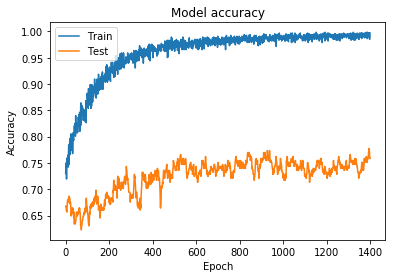

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()